In [1]:
#Import all the packages that will be using in this project
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib
from matplotlib import pylab as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from  sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVR
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## 1. Import Data and EDA

In [2]:
#Import the ride dataset

rides = pd.read_csv('uber_lyft_dataset/cab_rides.csv')

In [3]:
rides.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL


In [4]:
#Import the weather dataset
weather = pd.read_csv('uber_lyft_dataset/weather.csv')

In [5]:
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


In [6]:
rides.shape

(693071, 10)

In [7]:
rides.dtypes

distance            float64
cab_type             object
time_stamp            int64
destination          object
source               object
price               float64
surge_multiplier    float64
id                   object
product_id           object
name                 object
dtype: object

In [8]:
#Number of trips in Uber
print('Uber:', rides[rides['cab_type'] == 'Uber'].shape)

#Number of trips in Lyft
print('Lyft:', rides[rides['cab_type']=='Lyft'].shape)

Uber: (385663, 10)
Lyft: (307408, 10)


In [9]:
#Convert time_stamp in rides to human readable version
rides['Date_Time'] = pd.to_datetime(rides['time_stamp'], unit='ms')
rides.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,Date_Time
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.677
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-28 01:00:22.198
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223


In [10]:
# Create new columns Date and Hour_of_day for better analysis later
rides['Date'] = rides['Date_Time'].dt.date
rides['Hour_of_day'] = rides['Date_Time'].dt.hour
rides.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,Date_Time,Date,Hour_of_day
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890,2018-12-16,9
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.677,2018-11-27,2
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-28 01:00:22.198,2018-11-28,1
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749,2018-11-30,4
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223,2018-11-29,3


In [11]:
#Convert time_stamp in weather to human readable version
weather['Date_Time'] = pd.to_datetime(weather['time_stamp'], unit='s')
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind,Date_Time
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25,2018-12-16 23:45:01
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32,2018-12-16 23:45:01
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07,2018-12-16 23:45:01
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09,2018-12-16 23:45:01
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49,2018-12-16 23:45:01


In [12]:
weather['Date']=weather['Date_Time'].dt.date
weather['Hour_of_day']=weather['Date_Time'].dt.hour
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind,Date_Time,Date,Hour_of_day
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25,2018-12-16 23:45:01,2018-12-16,23
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32,2018-12-16 23:45:01,2018-12-16,23
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07,2018-12-16 23:45:01,2018-12-16,23
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09,2018-12-16 23:45:01,2018-12-16,23
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49,2018-12-16 23:45:01,2018-12-16,23


In [13]:
rides['product_id'].value_counts()

product_id
6f72dfc5-27f1-42e8-84db-ccc7a75f6969    55096
9a0e7b09-b92b-4c41-9779-2ad22b4d779d    55096
6d318bcc-22a3-4af6-bddd-b409bfce1546    55096
6c84fd89-3f11-4782-9b50-97c468b19529    55095
8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a    55095
55c66225-fbe7-4fd5-9072-eab1ece5e23e    55094
997acbb5-e102-41e1-b155-9df7de0a73f2    55091
lyft_premier                            51235
lyft                                    51235
lyft_luxsuv                             51235
lyft_plus                               51235
lyft_lux                                51235
lyft_line                               51233
Name: count, dtype: int64

In [14]:
rides['name'].value_counts()

name
UberXL          55096
WAV             55096
Black SUV       55096
Black           55095
Taxi            55095
UberX           55094
UberPool        55091
Lux             51235
Lyft            51235
Lux Black XL    51235
Lyft XL         51235
Lux Black       51235
Shared          51233
Name: count, dtype: int64

the columns 'product_id' and 'name' are describing the same thing, will drop one of the columns later.

In [15]:
rides['id'].value_counts()

id
424553bb-7174-41ea-aeb4-fe06d4f4b9d7    1
86557077-556d-4cc0-8acf-4d618d5c0a8d    1
fa75d4b4-52c8-4e65-a5e6-335c8268c968    1
2d051bf0-4e5e-4b18-a931-ea15c4fb9066    1
7339fbe3-b0bb-4bac-a037-b1dc2ab0feac    1
                                       ..
0281be2d-1573-47a5-868d-fef6100d1b77    1
33827bd1-5164-4579-b567-14e85220c99b    1
6c736bfe-40d0-47b9-be59-ef41d9df516b    1
7311da4b-0932-4572-97ee-242a9e5f0229    1
e7fdc087-fe86-40a5-a3c3-3b2a8badcbda    1
Name: count, Length: 693071, dtype: int64

the column 'id' is just an id assigned to each row (each trip), will drop column also.

In [16]:
rides['surge_multiplier'].value_counts()

surge_multiplier
1.00    672096
1.25     11085
1.50      5065
1.75      2420
2.00      2239
2.50       154
3.00        12
Name: count, dtype: int64

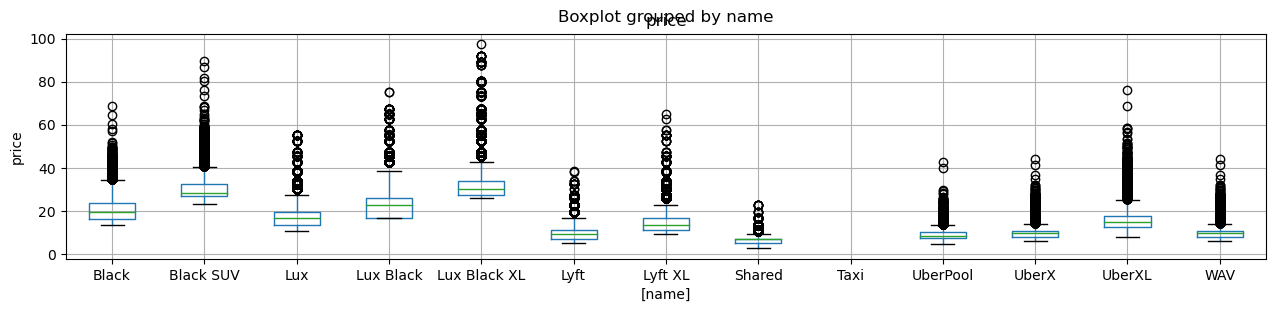

In [17]:
rides[['price','name']].boxplot(by='name',figsize=(15,3))
plt.ylabel('price')
plt.show()

In [18]:
rides[rides['name'] == 'Taxi'].count()

distance            55095
cab_type            55095
time_stamp          55095
destination         55095
source              55095
price                   0
surge_multiplier    55095
id                  55095
product_id          55095
name                55095
Date_Time           55095
Date                55095
Hour_of_day         55095
dtype: int64

When 'name' = 'Taxi', the price tends to be empty. We will drop rows with 'Taxi'.

In [19]:
rides = rides.dropna()

In [20]:
rides[rides['name'] == 'Taxi'].count()

distance            0
cab_type            0
time_stamp          0
destination         0
source              0
price               0
surge_multiplier    0
id                  0
product_id          0
name                0
Date_Time           0
Date                0
Hour_of_day         0
dtype: int64

In [21]:
#Drop the columns mentioned above, also drop time_stamp and Date_Time because we have converted it into Date and Hour of Day
rides = rides.drop(columns=['time_stamp', 'id', 'product_id', 'Date_Time'])
rides.head()

,distance,cab_type,destination,source,price,surge_multiplier,name,Date,Hour_of_day
0,0.44,Lyft,North Station,Haymarket Square,5.0,1.0,Shared,2018-12-16,9
1,0.44,Lyft,North Station,Haymarket Square,11.0,1.0,Lux,2018-11-27,2
2,0.44,Lyft,North Station,Haymarket Square,7.0,1.0,Lyft,2018-11-28,1
3,0.44,Lyft,North Station,Haymarket Square,26.0,1.0,Lux Black XL,2018-11-30,4
4,0.44,Lyft,North Station,Haymarket Square,9.0,1.0,Lyft XL,2018-11-29,3


In [22]:
#Group the weather by location, date, and hour of day, find the mean for each feature
weather_ = weather.groupby(['location', 'Date','Hour_of_day']).mean()
weather_.head()

temp    clouds     pressure  rain  \
location Date       Hour_of_day                                           
Back Bay 2018-11-26 3            41.040000  0.870000  1014.390000   NaN   
                    4            40.658000  0.894000  1014.008000   NaN   
                    5            40.561250  0.930000  1013.821250   NaN   
                    6            40.627333  0.990667  1014.196667   NaN   
                    7            41.137500  0.970000  1014.292500   NaN   

                                   time_stamp  humidity      wind  \
location Date       Hour_of_day                                     
Back Bay 2018-11-26 3            1.543204e+09  0.920000  1.460000   
                    4            1.543208e+09  0.926000  2.646000   
                    5            1.543210e+09  0.921250  2.496250   
                    6            1.543214e+09  0.913333  1.350667   
                    7            1.543217e+09  0.920000  1.735000   

                                                    Date_Time  
location Date       Hour_of_day                                
Back Bay 2018-11-26 3           2018-11-26 03:40:45.000000000  
                    4           2018-11-26 04:46:13.600000000  
                    5           2018-11-26 05:23:56.750000128  
                    6           2018-11-26 06:25:16.466666752  
                    7           2018-11-26 07:28:12.750000128

I have also dropped time_stamp and Date_Time columns in the weather_ table.

In [23]:
weather_ = weather_.drop(columns=['time_stamp', 'Date_Time'])

In [24]:
#Merge two tables together, rides left join weather on source location, Date, and Hour_of_day 
ride_weather = pd.merge(rides, weather_,  how='left',  
                        left_on=['source','Date', 'Hour_of_day'], right_on = ['location','Date', 'Hour_of_day'])

In [25]:
ride_weather.head()

,distance,cab_type,destination,source,price,surge_multiplier,name,Date,Hour_of_day,temp,clouds,pressure,rain,humidity,wind
0,0.44,Lyft,North Station,Haymarket Square,5.0,1.0,Shared,2018-12-16,9,38.460,0.290000,1022.25,NaN,0.760000,7.68
1,0.44,Lyft,North Station,Haymarket Square,11.0,1.0,Lux,2018-11-27,2,44.065,0.995000,1002.88,0.106,0.895000,12.63
2,0.44,Lyft,North Station,Haymarket Square,7.0,1.0,Lyft,2018-11-28,1,NaN,NaN,NaN,NaN,NaN,NaN
3,0.44,Lyft,North Station,Haymarket Square,26.0,1.0,Lux Black XL,2018-11-30,4,35.080,0.000000,1013.71,NaN,0.700000,5.25
4,0.44,Lyft,North Station,Haymarket Square,9.0,1.0,Lyft XL,2018-11-29,3,37.680,0.433333,998.42,NaN,0.706667,11.16


In [26]:
print('data dimensions:',ride_weather.shape)
perc_missing_per_ftr = ride_weather.isnull().sum(axis=0)/rides.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])

data dimensions: (637976, 15)
fraction of missing values in features:
temp        0.004285
clouds      0.004285
pressure    0.004285
rain        0.828909
humidity    0.004285
wind        0.004285
dtype: float64


Some Distribution Plot

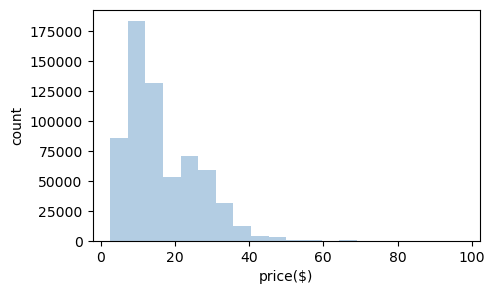

In [27]:
plt.figure(figsize=(5,3))
ride_weather['price'].plot.hist(bins = 20, color = '#B3CDE3')              
plt.xlabel('price($)')
plt.ylabel('count')
plt.show()

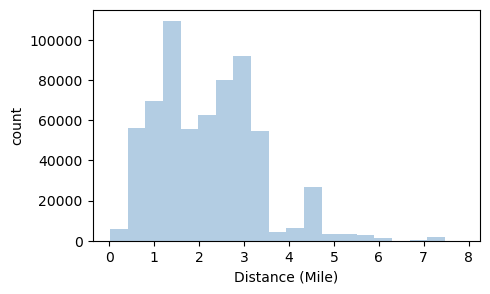

In [28]:
plt.figure(figsize=(5,3))
ride_weather['distance'].plot.hist(bins = 20, color = '#B3CDE3')            
plt.xlabel('Distance (Mile)')
plt.ylabel('count')
plt.show()

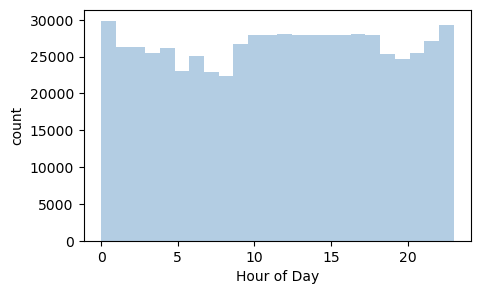

In [29]:
plt.figure(figsize=(5,3))
ride_weather['Hour_of_day'].plot.hist(bins = 24, color = '#B3CDE3')              
plt.xlabel('Hour of Day')
plt.ylabel('count')
plt.show()

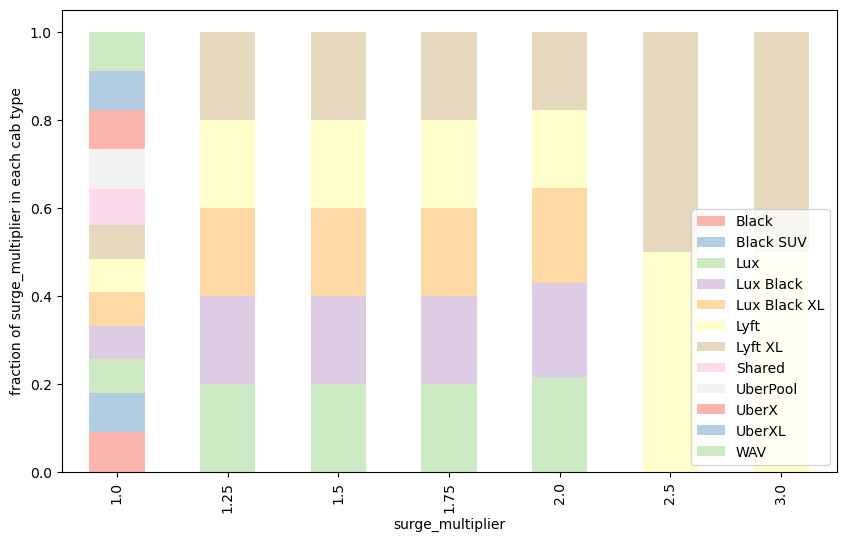

In [31]:
custom_palette = ['#FBB4AE','#B3CDE3','#CCEBC5','#DECBE4','#FED9A6','#FFFFCC','#E5D8BD','#FDDAEC','#F2F2F2']
sns.set_palette(custom_palette)
count_matrix = ride_weather.groupby(['surge_multiplier', 'name']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(10,6))
plt.ylabel('fraction of surge_multiplier in each cab type')
plt.legend(loc=4)
plt.show()

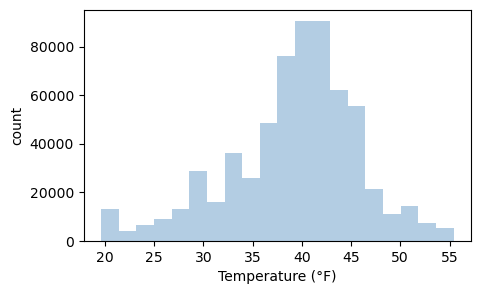

In [32]:
plt.figure(figsize=(5,3))
ride_weather['temp'].plot.hist(bins = 20, color = '#B3CDE3')             
plt.xlabel('Temperature (°F)')
plt.ylabel('count')
plt.show()

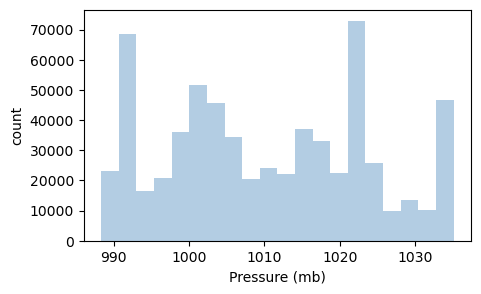

In [33]:
plt.figure(figsize=(5,3))
ride_weather['pressure'].plot.hist(bins = 20, color = '#B3CDE3')             
plt.xlabel('Pressure (mb)')
plt.ylabel('count')
plt.show()

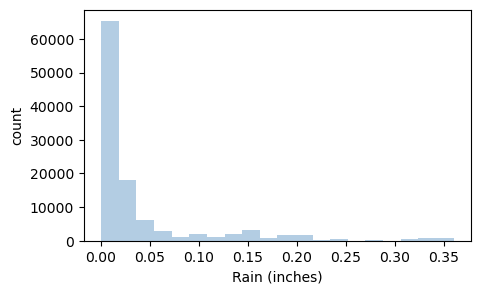

In [34]:
plt.figure(figsize=(5,3))
ride_weather['rain'].plot.hist(bins = 20, color = '#B3CDE3')             
plt.xlabel('Rain (inches)')
plt.ylabel('count')
plt.show()

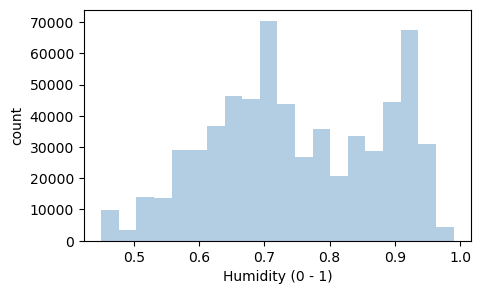

In [35]:
plt.figure(figsize=(5,3))
ride_weather['humidity'].plot.hist(bins = 20, color = '#B3CDE3')             
plt.xlabel('Humidity (0 - 1)')
plt.ylabel('count')
plt.show()

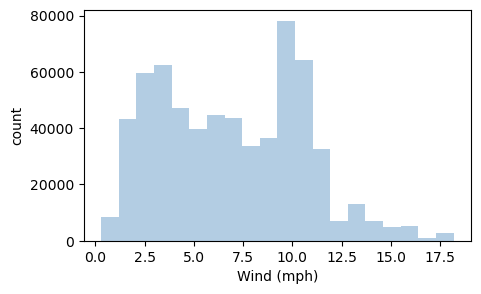

In [36]:
plt.figure(figsize=(5,3))
ride_weather['wind'].plot.hist(bins = 20, color = '#B3CDE3')             
plt.xlabel('Wind (mph)')
plt.ylabel('count')
plt.show()

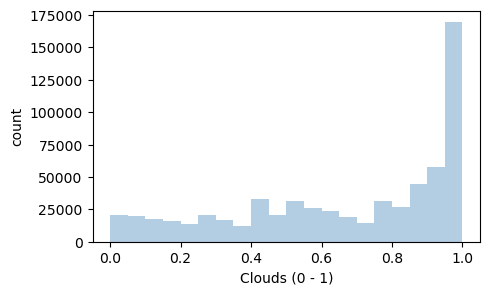

In [37]:
plt.figure(figsize=(5,3))
ride_weather['clouds'].plot.hist(bins = 20, color = '#B3CDE3')             
plt.xlabel('Clouds (0 - 1)')
plt.ylabel('count')
plt.show()

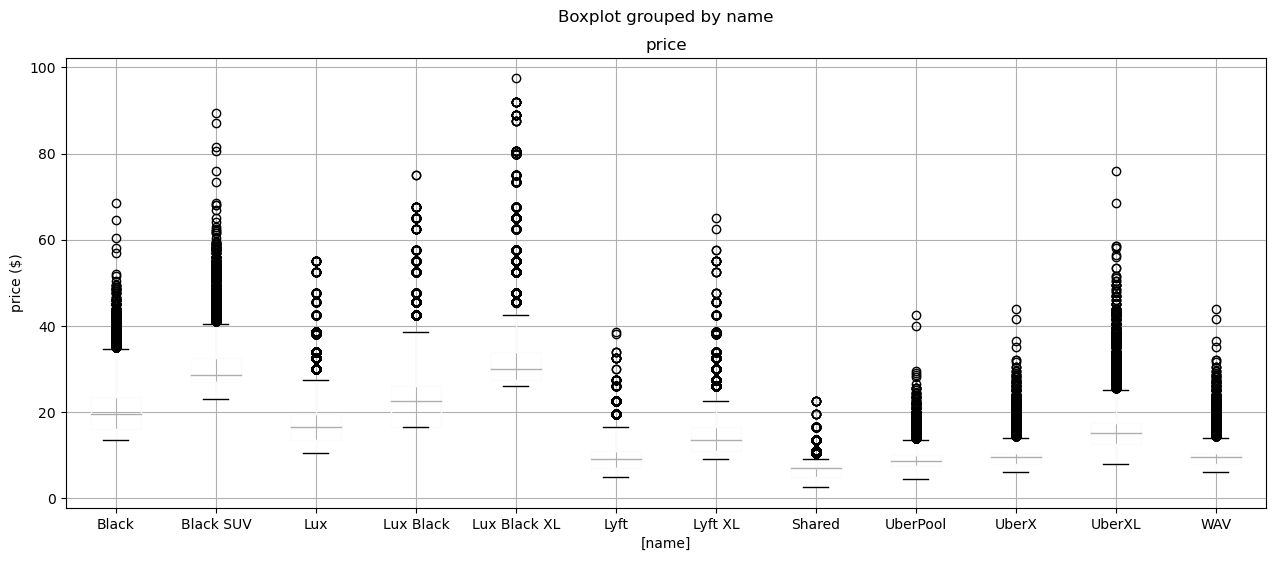

In [38]:
ride_weather[['price','name']].boxplot(by='name',figsize=(15,6))
plt.ylabel('price ($)')
plt.show()

I want to look at tables of Uber of Lyft seperately.

In [39]:
uber = rides[rides['cab_type'] == 'Uber']

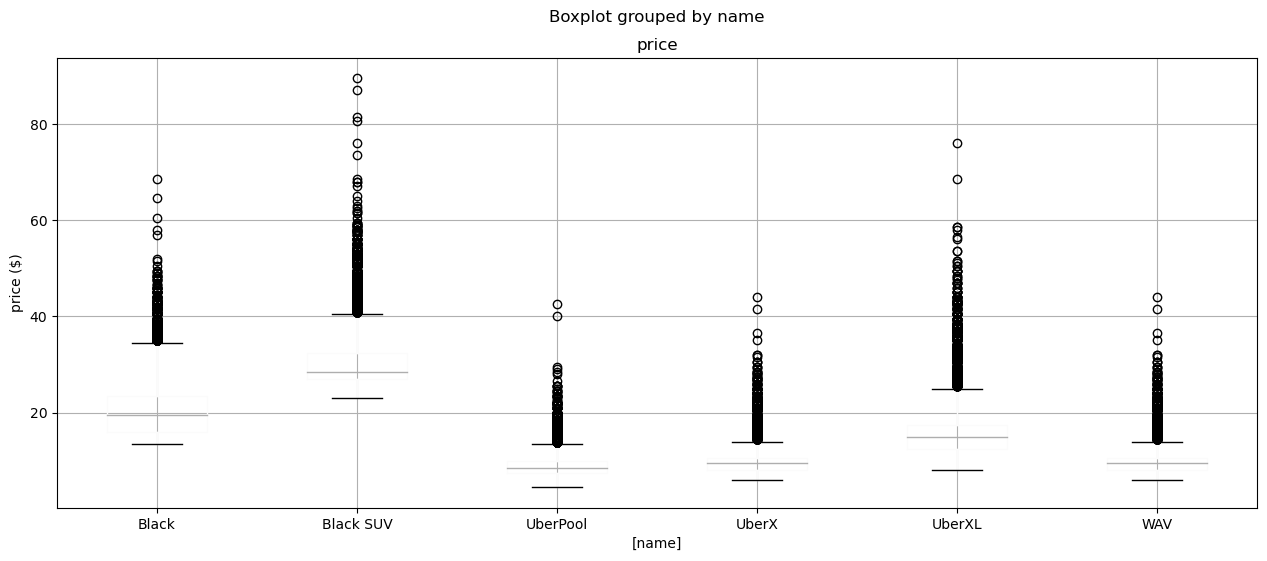

In [40]:
uber[['price','name']].boxplot(by='name',figsize=(15,6))
plt.ylabel('price ($)')
plt.show()

In [41]:
lyft = rides[rides['cab_type'] == 'Lyft']

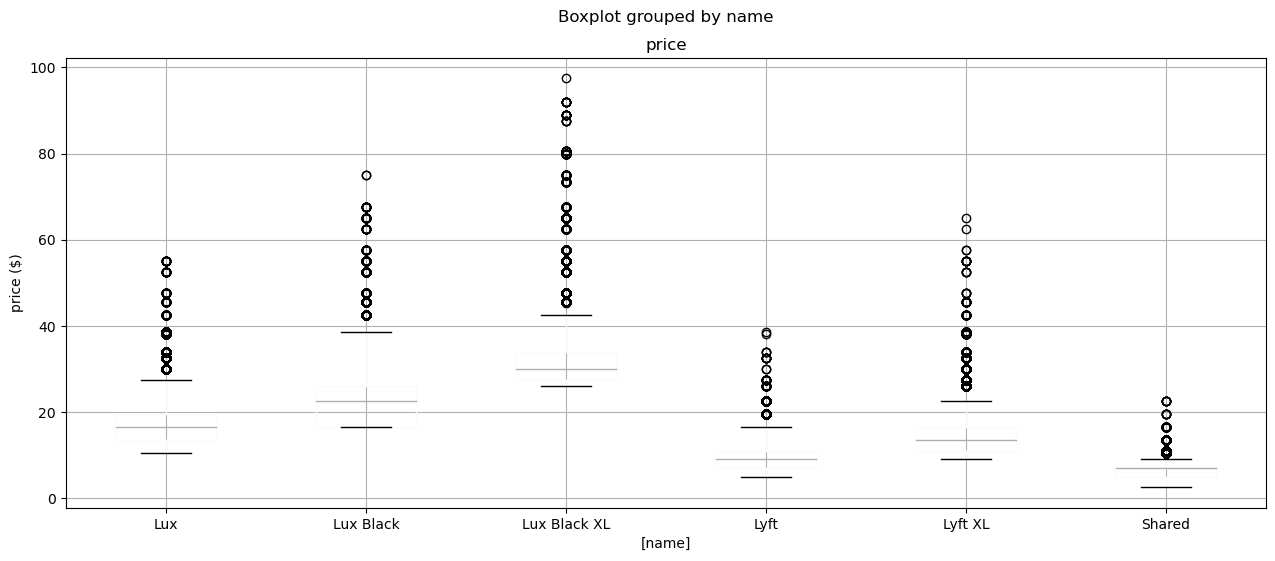

In [42]:
lyft[['price','name']].boxplot(by='name', figsize=(15,6))
plt.ylabel('price ($)')
plt.show()

Since uber and lyft have similar 'name' feature, such that they make similar ride type different names. I will make the similar ride types the same name. For example, uberpool and shared will all be shared. Lyft and Uberx will change to standard...

In [43]:
ride_weather = ride_weather.replace('UberPool', 'Shared')
ride_weather = ride_weather.replace('Lyft XL', 'XL')
ride_weather = ride_weather.replace('UberXL', 'XL')
ride_weather = ride_weather.replace('UberX', 'Standard')
ride_weather['name'] = ride_weather['name'].replace('Lyft', 'Standard')
ride_weather = ride_weather.replace('WAV', 'Standard')
#premium black car service in luxury vehicles
ride_weather = ride_weather.replace('Lux Black XL', 'Lux/Black XL')
ride_weather = ride_weather.replace('Black SUV', 'Lux/Black XL')
ride_weather = ride_weather.replace('Lux', 'Lux/Black')
ride_weather = ride_weather.replace('Black', 'Lux/Black')

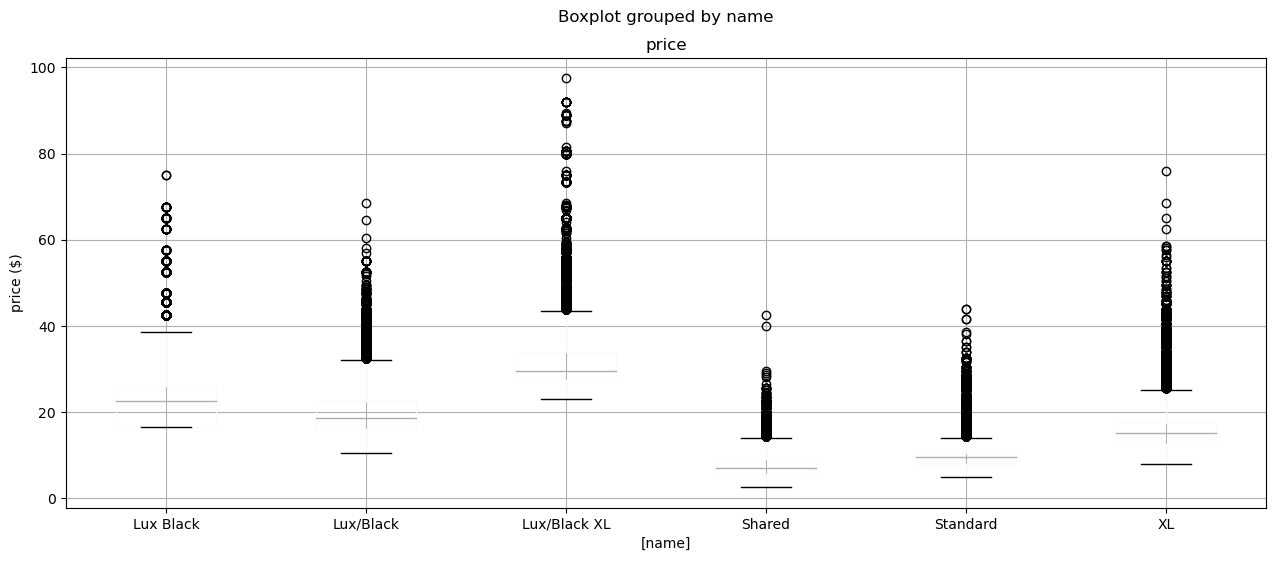

In [44]:
ride_weather[['price','name']].boxplot(by='name',figsize=(15,6))
plt.ylabel('price ($)')
plt.show()

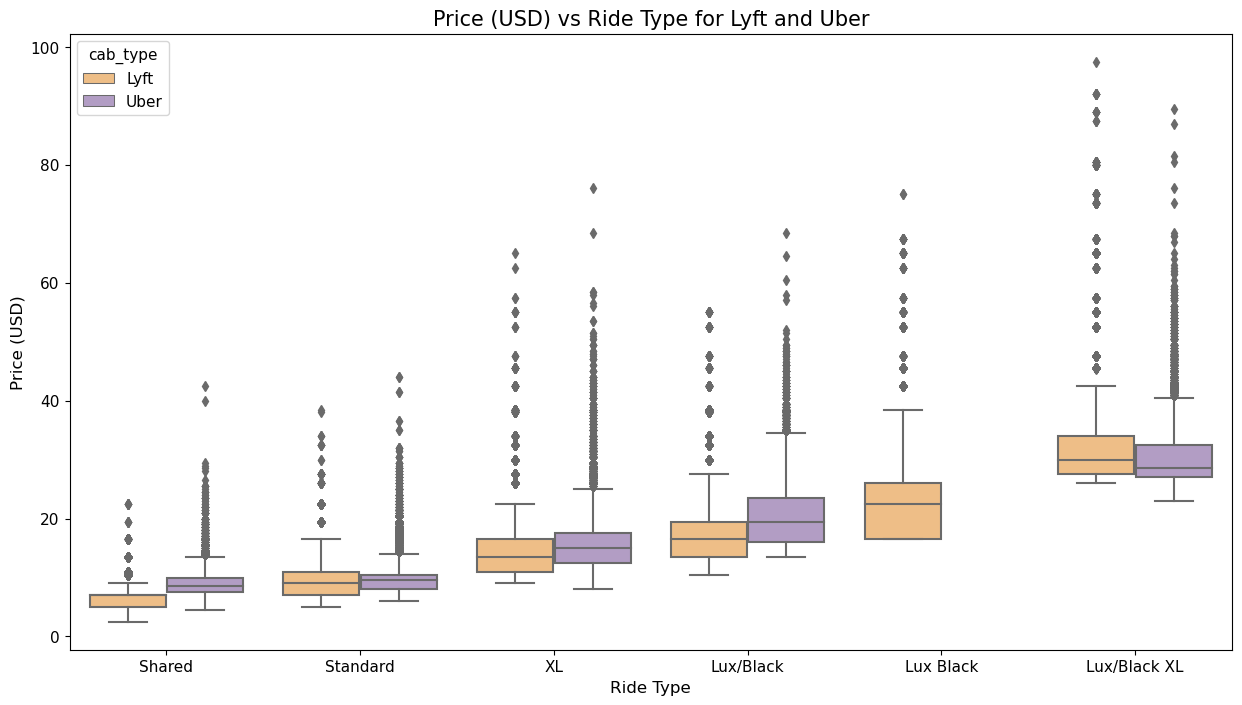

In [190]:
sns.set_palette(['#FFBF76', '#B396CB'])
fig, ax = plt.subplots(figsize=(15, 8))
plot1 = sns.boxplot(data = ride_weather, x="ride_type", y="price", hue="cab_type", ax = ax, 
            order = ['Shared', 'Standard', 'XL', 'Lux/Black', 'Lux Black', 'Lux/Black XL'])

plot1.set_xlabel( "Ride Type" , size = 12) 
plot1.set_ylabel( "Price (USD)" , size = 12) 
plot1.set_title( "Price (USD) vs Ride Type for Lyft and Uber" , size = 15 ) 
#plot1.set(xlabel='Ride Type', ylabel='Price ($)')
plt.savefig("/Users/winniezhang/Desktop/data1030_project/Price_vs_Ride_Type.png", format='png', dpi = 1200)
plt.show()

<Axes: xlabel='rain', ylabel='price'>

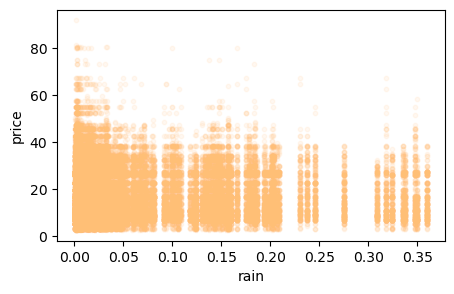

In [46]:
ride_weather.plot.scatter('rain','price',figsize=(5,3),alpha=0.1,s=10)

<Axes: xlabel='surge_multiplier', ylabel='price'>

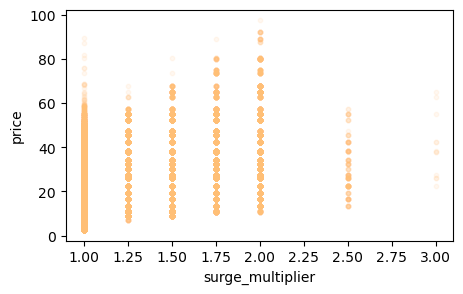

In [47]:
ride_weather.plot.scatter('surge_multiplier','price',figsize=(5,3),alpha=0.1,s=10)

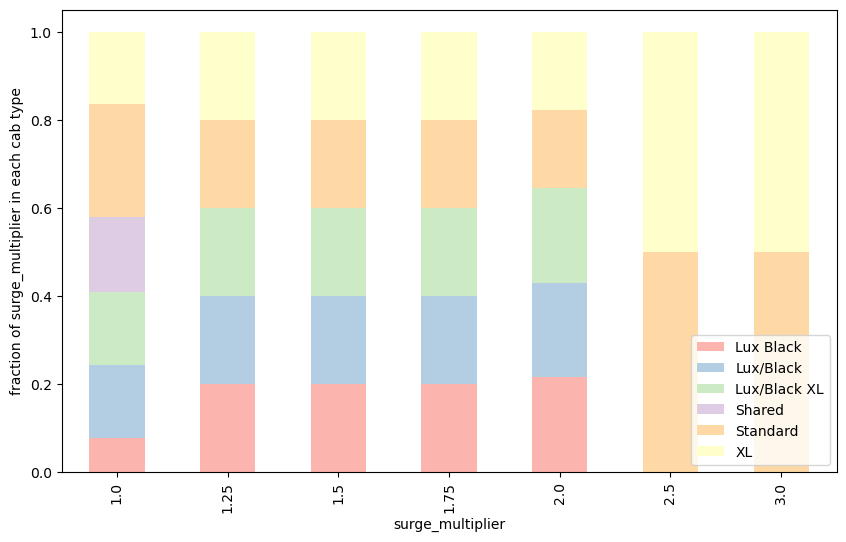

In [48]:
custom_palette = ['#FBB4AE','#B3CDE3','#CCEBC5','#DECBE4','#FED9A6','#FFFFCC','#E5D8BD','#FDDAEC','#F2F2F2']
sns.set_palette(custom_palette)
count_matrix = ride_weather.groupby(['surge_multiplier', 'name']).size().unstack()
count_matrix_norm = count_matrix.div(count_matrix.sum(axis=1),axis=0)
count_matrix_norm.plot(kind='bar', stacked=True,figsize=(10,6))
plt.ylabel('fraction of surge_multiplier in each cab type')
plt.legend(loc=4)
plt.show()

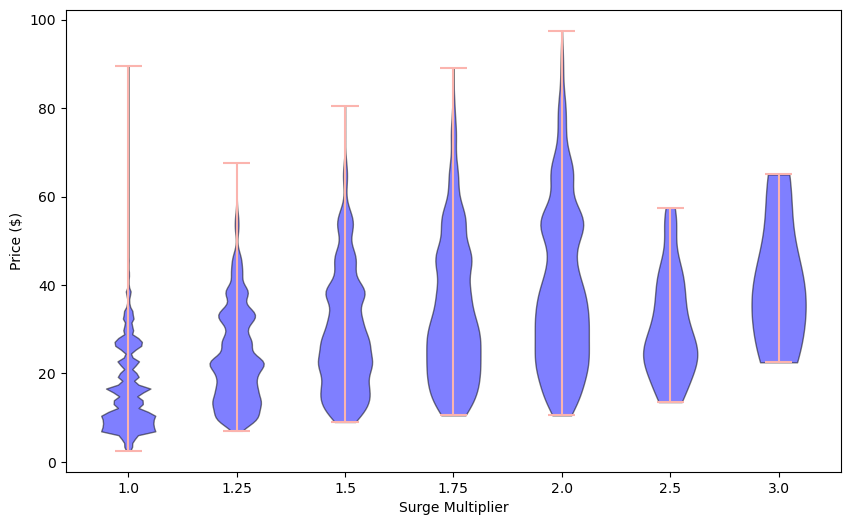

In [49]:
dataset = [ride_weather[ride_weather['surge_multiplier']== 1.0]['price'].values,
           ride_weather[ride_weather['surge_multiplier']== 1.25]['price'].values,
           ride_weather[ride_weather['surge_multiplier']== 1.5]['price'].values,
           ride_weather[ride_weather['surge_multiplier']== 1.75]['price'].values,
           ride_weather[ride_weather['surge_multiplier']== 2.0]['price'].values,
           ride_weather[ride_weather['surge_multiplier']== 2.5]['price'].values,
           ride_weather[ride_weather['surge_multiplier']== 3.0]['price'].values]

plt.figure(figsize=(10,6))

violin = plt.violinplot(dataset = dataset)
for pc in violin["bodies"]:
    pc.set_facecolor("blue")
    pc.set_edgecolor("black")
    pc.set_alpha(0.5)
plt.xticks([1,2, 3, 4, 5, 6, 7],['1.0','1.25', '1.5', '1.75', '2.0', '2.5', '3.0'])
plt.xlabel('Surge Multiplier')
plt.ylabel('Price ($)')
plt.show()

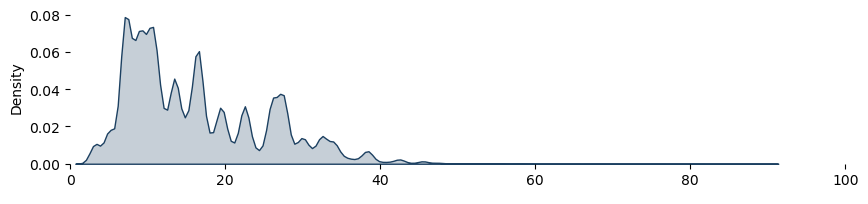

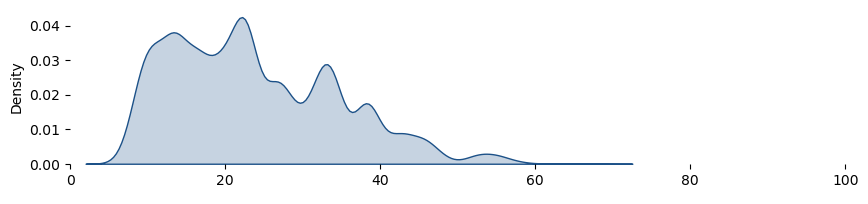

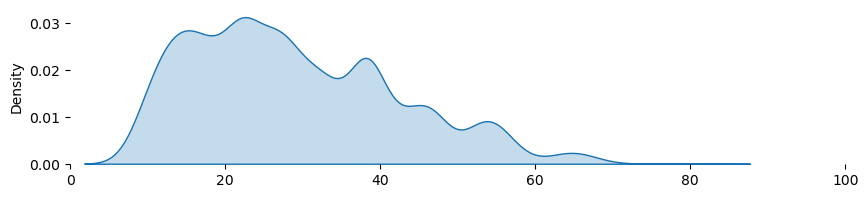

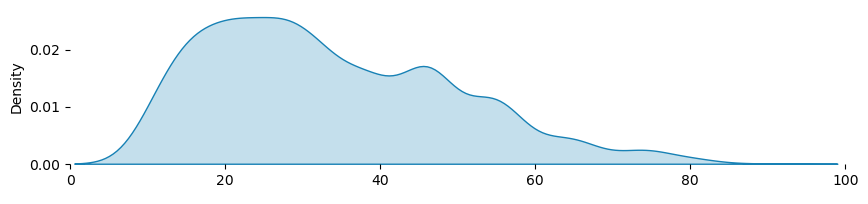

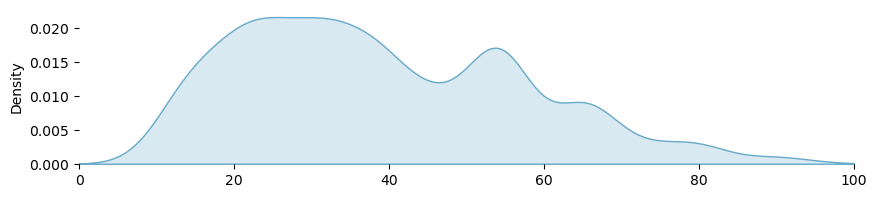

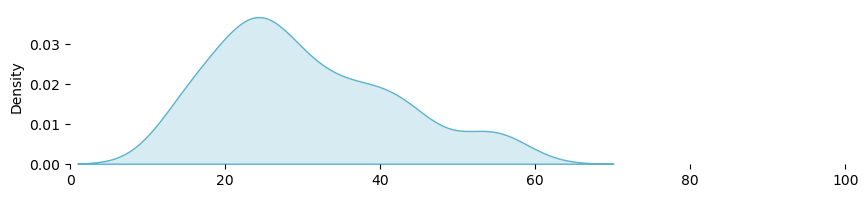

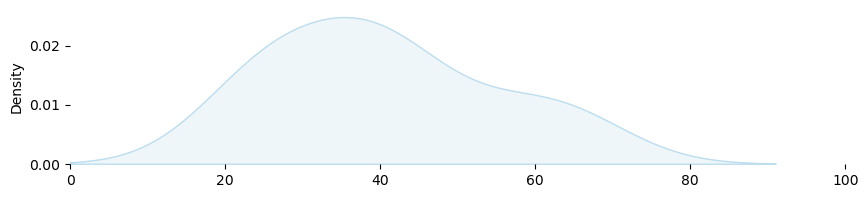

In [50]:
custom_palette = ['#1c4061', '#1c5188', '#1772B4','#1781B5','#66A9C9','#5CB3CC','#BCDDED','#CBE7D7','#A5D6D0','#69A794','#3EA894']
i = 0
for surge_multiplier, data in ride_weather.groupby('surge_multiplier'):
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.set_xlim(0,100)
    ax.set_xlabel( " " , size = 1 ) 
    sns.despine(bottom = True, left = True)
    sns.kdeplot(data['price'], ax=ax, fill = 'true', label = surge_multiplier, color = custom_palette[i])
    i += 1

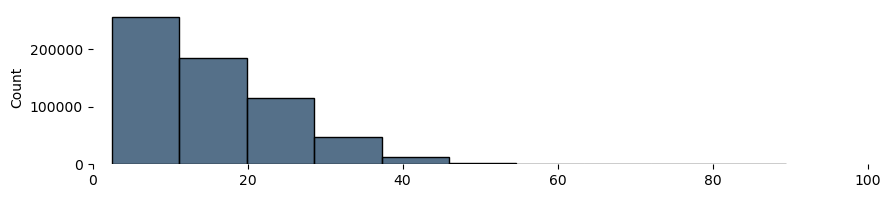

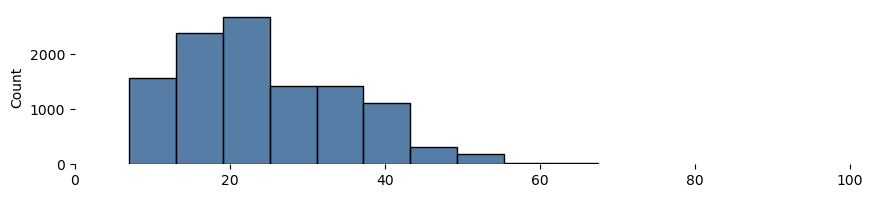

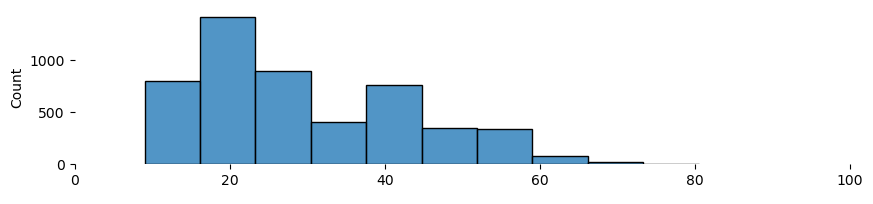

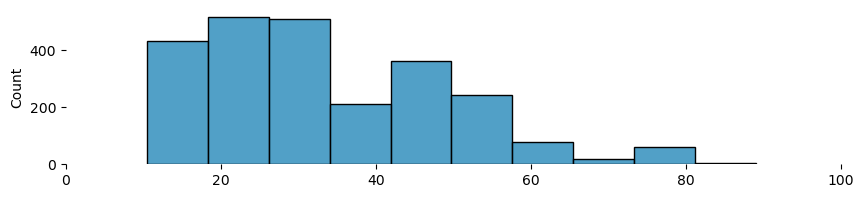

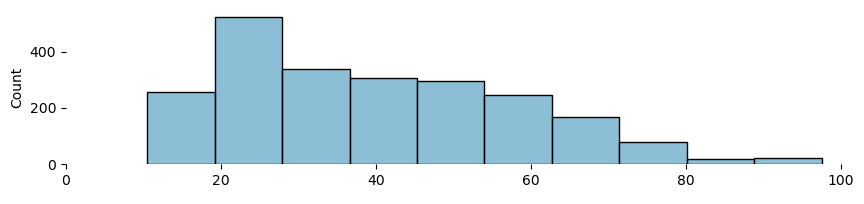

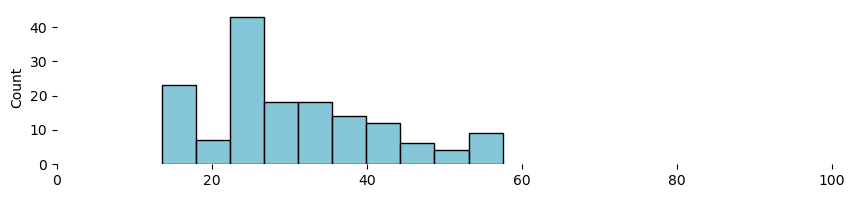

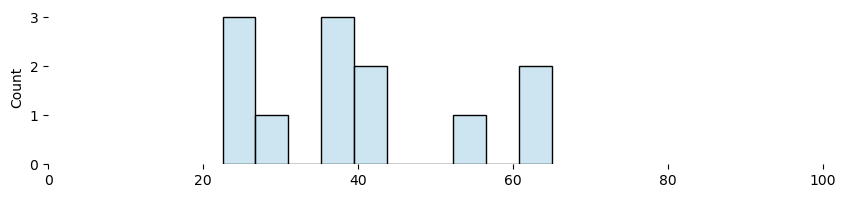

In [51]:
custom_palette = ['#1c4061', '#1c5188', '#1772B4','#1781B5','#66A9C9','#5CB3CC','#BCDDED','#CBE7D7','#A5D6D0','#69A794','#3EA894']
i = 0
for surge_multiplier, data in ride_weather.groupby('surge_multiplier'):
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.set_xlim(0,100)
    ax.set_xlabel( " " , size = 1 ) 
    sns.despine(bottom = True, left = True)
    sns.histplot(data['price'], ax=ax, fill = 'true', label = surge_multiplier, color = custom_palette[i], bins = 10)
    i += 1

In [ ]:
custom_palette = ['#1c4061', '#1c5188', '#1772B4','#1781B5','#66A9C9','#5CB3CC','#BCDDED','#CBE7D7','#A5D6D0','#69A794','#3EA894']

fig, axs = plt.subplots(7, sharex=True, sharey=True)
fig.suptitle('Sharing both axes')
axs[0].plot(x, y ** 2)
axs[1].plot(x, 0.3 * y, 'o')
axs[2].plot(x, y, '+')

custom_palette = ['#1c4061', '#1c5188', '#1772B4','#1781B5','#66A9C9','#5CB3CC','#BCDDED','#CBE7D7','#A5D6D0','#69A794','#3EA894']
i = 0
for surge_multiplier, data in ride_weather.groupby('surge_multiplier'):
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.set_xlim(0,100)
    ax.set_xlabel( " " , size = 1 ) 
    sns.despine(bottom = True, left = True)
    sns.histplot(data['price'], ax=ax, fill = 'true', label = surge_multiplier, color = custom_palette[i], bins = 10)
    i += 1

In [197]:
price_by_surge = []
surge_multipliers = []
for surge_multiplier, data in ride_weather.groupby('surge_multiplier'):
    surge_multipliers.append(surge_multiplier)
    price_by_surge.append(data['price'])

In [220]:
str(round(surge_multipliers[2], 2))

'1.5'

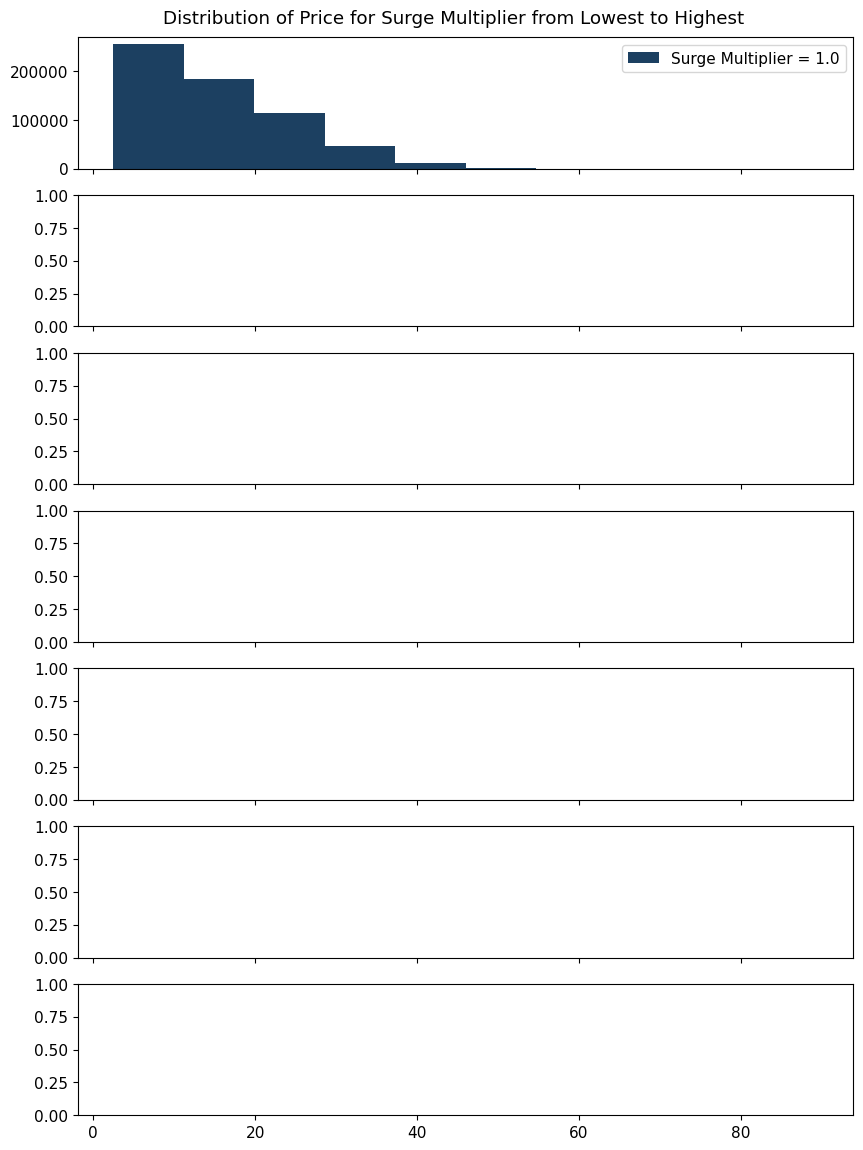

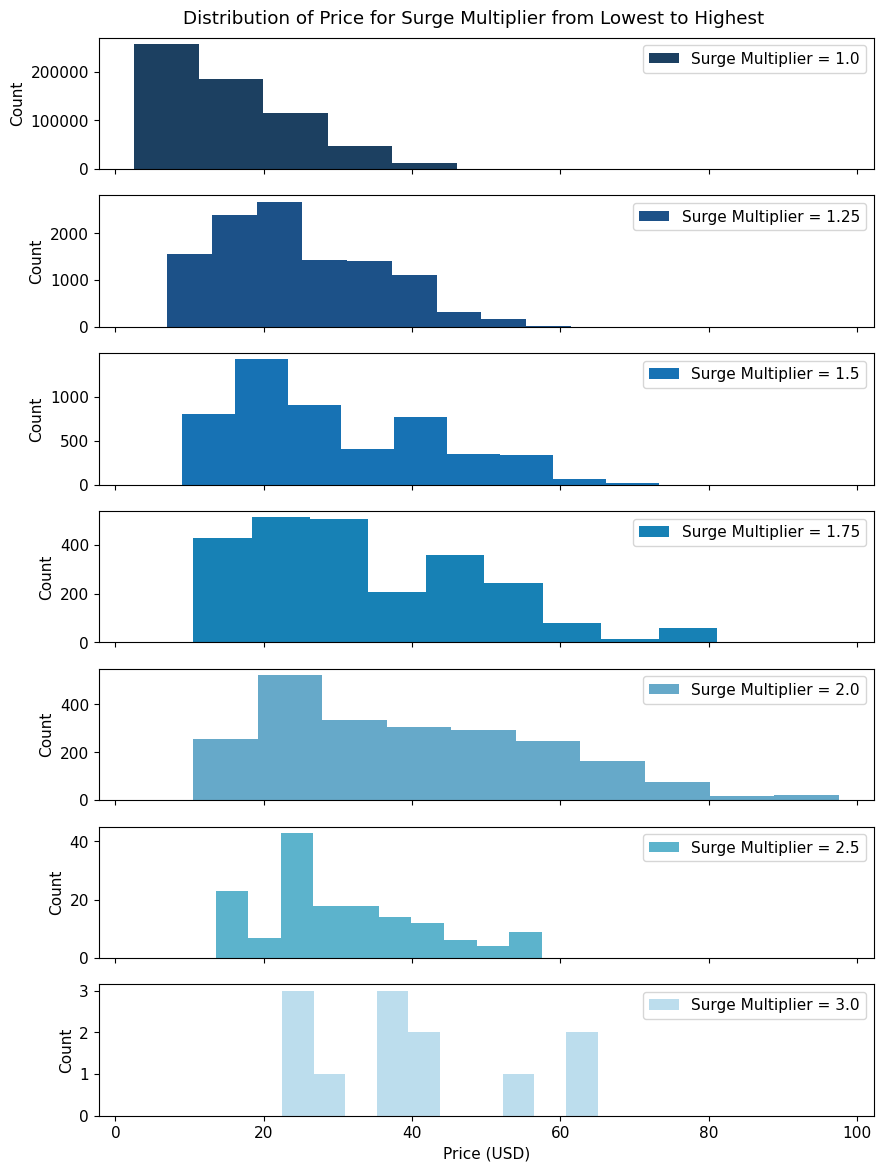

In [350]:
custom_palette = ['#1c4061', '#1c5188', '#1772B4','#1781B5','#66A9C9','#5CB3CC','#BCDDED','#CBE7D7','#A5D6D0','#69A794','#3EA894']

fig, axs = plt.subplots(7, sharex=True, figsize=(10, 14))
fig.suptitle('Distribution of Price for Surge Multiplier from Lowest to Highest',  x = 0.5, y = 0.90)
for i in range(len(surge_multipliers)):
    surge_multiplier = "Surge Multiplier = " + str(round(surge_multipliers[i], 3))
    axs[i].hist(price_by_surge[i], color = custom_palette[i], label = surge_multiplier)
    axs[i].legend(loc = "upper right")
    axs[i].set_ylabel('Count')
plt.xlabel('Price (USD)')
plt.savefig("/Users/winniezhang/Desktop/data1030_project/Distribution_of_Price_for_Surge.png", format='png', dpi = 1200)
plt.show()

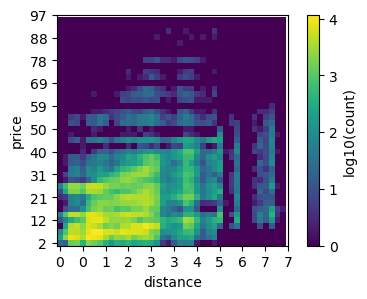

In [52]:
nbins = 40

heatmap, xedges, yedges = np.histogram2d(ride_weather['distance'], ride_weather['price'], bins=nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

heatmap[heatmap == 0] = 0.1 # we will use log and log(0) is undefined
plt.figure(figsize=(5,3))

plt.imshow(np.log10(heatmap).T, origin='lower',vmin=0) # use log count
#plt.imshow(heatmap.T, origin='lower',vmin=0) # use log count
plt.xlabel('distance')
plt.ylabel('price')
plt.xticks(np.arange(nbins+1)[::4],xedges[::4].astype(int))
plt.yticks(np.arange(nbins+1)[::4],yedges[::4].astype(int))
plt.colorbar(label='log10(count)')
plt.show()

In [53]:
ride_weather['Date'].value_counts()

Date
2018-11-27    70135
2018-11-28    67842
2018-11-29    55222
2018-12-01    41680
2018-11-30    41544
2018-12-16    41359
2018-12-17    41354
2018-12-14    41344
2018-12-15    41332
2018-12-03    41323
2018-12-02    41298
2018-12-13    35496
2018-12-18    33329
2018-11-26    29028
2018-12-04    11627
2018-12-10     2534
2018-12-09     1529
Name: count, dtype: int64

In [54]:
ride_weather['Date'] = pd.to_datetime(ride_weather['Date'], format='%Y-%m-%d')

In [55]:
#Add a new column day of week to find new insights
ride_weather['day_of_week'] = ride_weather['Date'].dt.dayofweek

In [56]:
ride_weather.head()

,distance,cab_type,destination,source,price,surge_multiplier,name,Date,Hour_of_day,temp,clouds,pressure,rain,humidity,wind,day_of_week
0,0.44,Lyft,North Station,Haymarket Square,5.0,1.0,Shared,2018-12-16,9,38.460,0.290000,1022.25,NaN,0.760000,7.68,6
1,0.44,Lyft,North Station,Haymarket Square,11.0,1.0,Lux/Black,2018-11-27,2,44.065,0.995000,1002.88,0.106,0.895000,12.63,1
2,0.44,Lyft,North Station,Haymarket Square,7.0,1.0,Standard,2018-11-28,1,NaN,NaN,NaN,NaN,NaN,NaN,2
3,0.44,Lyft,North Station,Haymarket Square,26.0,1.0,Lux/Black XL,2018-11-30,4,35.080,0.000000,1013.71,NaN,0.700000,5.25,4
4,0.44,Lyft,North Station,Haymarket Square,9.0,1.0,XL,2018-11-29,3,37.680,0.433333,998.42,NaN,0.706667,11.16,3


In [57]:
ride_weather['day_of_week'] = ride_weather['day_of_week'].map({
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
})

In [58]:
ride_weather.head()

,distance,cab_type,destination,source,price,surge_multiplier,name,Date,Hour_of_day,temp,clouds,pressure,rain,humidity,wind,day_of_week
0,0.44,Lyft,North Station,Haymarket Square,5.0,1.0,Shared,2018-12-16,9,38.460,0.290000,1022.25,NaN,0.760000,7.68,Sunday
1,0.44,Lyft,North Station,Haymarket Square,11.0,1.0,Lux/Black,2018-11-27,2,44.065,0.995000,1002.88,0.106,0.895000,12.63,Tuesday
2,0.44,Lyft,North Station,Haymarket Square,7.0,1.0,Standard,2018-11-28,1,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday
3,0.44,Lyft,North Station,Haymarket Square,26.0,1.0,Lux/Black XL,2018-11-30,4,35.080,0.000000,1013.71,NaN,0.700000,5.25,Friday
4,0.44,Lyft,North Station,Haymarket Square,9.0,1.0,XL,2018-11-29,3,37.680,0.433333,998.42,NaN,0.706667,11.16,Thursday


Text(0, 0.5, 'Frequency')

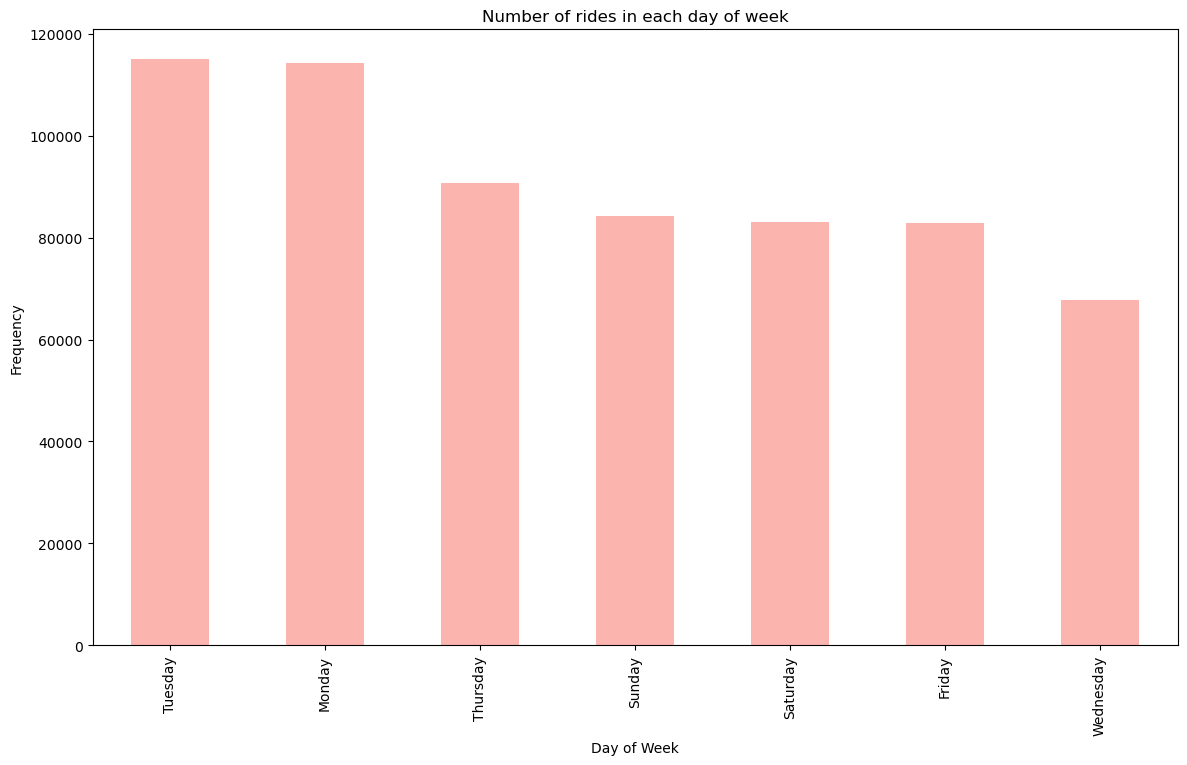

In [59]:
ax = ride_weather['day_of_week'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of rides in each day of week")
ax.set_xlabel("Day of Week")
ax.set_ylabel("Frequency")

In [60]:
ride_weather['destination'].value_counts()

destination
Financial District         54192
Back Bay                   53190
Theatre District           53189
Haymarket Square           53171
Boston University          53171
Fenway                     53166
Northeastern University    53165
North End                  53164
South Station              53159
West End                   52992
Beacon Hill                52840
North Station              52577
Name: count, dtype: int64

In [61]:
ride_weather['source'].value_counts()

source
Financial District         54197
Back Bay                   53201
Theatre District           53201
Boston University          53172
North End                  53171
Fenway                     53166
Northeastern University    53164
South Station              53160
Haymarket Square           53147
West End                   52980
Beacon Hill                52841
North Station              52576
Name: count, dtype: int64

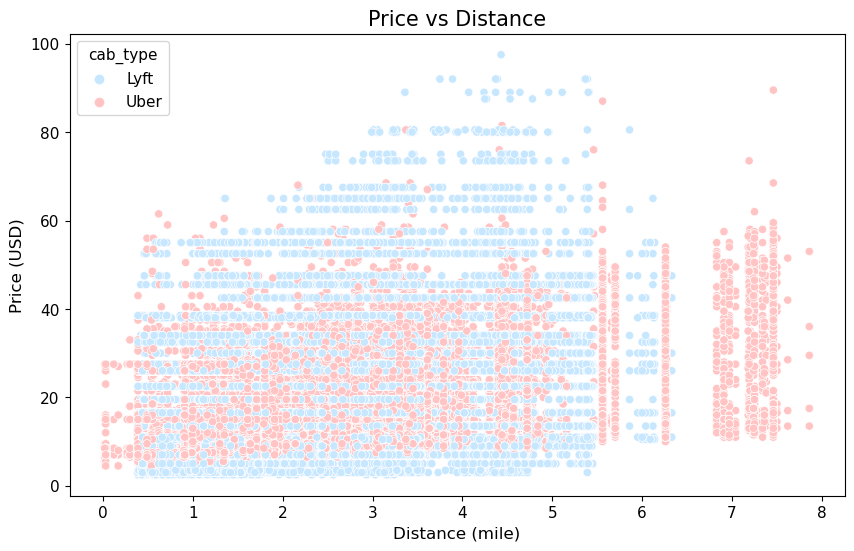

In [192]:
sns.set_palette(['#C7E7FF', '#FFC4C3'])
fig, ax = plt.subplots(figsize = ( 10 , 6 )) 
sns.scatterplot( ax = ax , x = "distance" , y = "price" , data = ride_weather, hue = "cab_type") 
ax.set_xlabel( "Distance (mile)" , size = 12 ) 
ax.set_ylabel( "Price (USD)" , size = 12 ) 
ax.set_title( "Price vs Distance" , size = 15) 
plt.savefig("/Users/winniezhang/Desktop/data1030_project/Price_vs_Distance.png", format='png', dpi = 1200)
plt.show()

In [63]:
ride_weather.shape

(637976, 16)

In [64]:
ride_weather[ride_weather['cab_type'] == 'Lyft'].shape

(307408, 16)

In [65]:
ride_weather[ride_weather['cab_type'] == 'Uber'].shape

(330568, 16)

In [66]:
perc_missing_per_ftr = ride_weather.isnull().sum(axis=0)/ride_weather.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
frac_missing = sum(ride_weather.isnull().sum(axis=1)!=0)/ride_weather.shape[0]
print('fraction of points with missing values:',frac_missing)

fraction of missing values in features:
temp        0.004285
clouds      0.004285
pressure    0.004285
rain        0.828909
humidity    0.004285
wind        0.004285
dtype: float64
fraction of points with missing values: 0.828908924473648


In [67]:
ride_weather.head()

,distance,cab_type,destination,source,price,surge_multiplier,name,Date,Hour_of_day,temp,clouds,pressure,rain,humidity,wind,day_of_week
0,0.44,Lyft,North Station,Haymarket Square,5.0,1.0,Shared,2018-12-16,9,38.460,0.290000,1022.25,NaN,0.760000,7.68,Sunday
1,0.44,Lyft,North Station,Haymarket Square,11.0,1.0,Lux/Black,2018-11-27,2,44.065,0.995000,1002.88,0.106,0.895000,12.63,Tuesday
2,0.44,Lyft,North Station,Haymarket Square,7.0,1.0,Standard,2018-11-28,1,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday
3,0.44,Lyft,North Station,Haymarket Square,26.0,1.0,Lux/Black XL,2018-11-30,4,35.080,0.000000,1013.71,NaN,0.700000,5.25,Friday
4,0.44,Lyft,North Station,Haymarket Square,9.0,1.0,XL,2018-11-29,3,37.680,0.433333,998.42,NaN,0.706667,11.16,Thursday


In [68]:
ride_weather = ride_weather.rename(columns={"name": "ride_type"})

In [69]:
ride_weather.head()

,distance,cab_type,destination,source,price,surge_multiplier,ride_type,Date,Hour_of_day,temp,clouds,pressure,rain,humidity,wind,day_of_week
0,0.44,Lyft,North Station,Haymarket Square,5.0,1.0,Shared,2018-12-16,9,38.460,0.290000,1022.25,NaN,0.760000,7.68,Sunday
1,0.44,Lyft,North Station,Haymarket Square,11.0,1.0,Lux/Black,2018-11-27,2,44.065,0.995000,1002.88,0.106,0.895000,12.63,Tuesday
2,0.44,Lyft,North Station,Haymarket Square,7.0,1.0,Standard,2018-11-28,1,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday
3,0.44,Lyft,North Station,Haymarket Square,26.0,1.0,Lux/Black XL,2018-11-30,4,35.080,0.000000,1013.71,NaN,0.700000,5.25,Friday
4,0.44,Lyft,North Station,Haymarket Square,9.0,1.0,XL,2018-11-29,3,37.680,0.433333,998.42,NaN,0.706667,11.16,Thursday


In [73]:
# Since we have a large dataset, it would be computationally expensive to train later. Therefore, we can apply stratified 
# sampling to group the datapoints according to source of the trip (since they equal weights in the raw dataset). 

ride_weather_subsampled = ride_weather.groupby('source', group_keys=False).apply(lambda x: x.sample(5000))

In [74]:
ride_weather_subsampled.shape

(60000, 16)

In [77]:
ride_weather_subsampled['day_of_week'].value_counts()

day_of_week
Tuesday      10849
Monday       10801
Thursday      8571
Sunday        7892
Saturday      7836
Friday        7699
Wednesday     6352
Name: count, dtype: int64

Fraction of missing points in the sample is similar to the whole data set

In [84]:
perc_missing_per_ftr = ride_weather_subsampled.isnull().sum(axis=0)/ride_weather_subsampled.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
frac_missing = sum(ride_weather_subsampled.isnull().sum(axis=1)!=0)/ride_weather_subsampled.shape[0]
print('fraction of points with missing values:',frac_missing)

fraction of missing values in features:
temp        0.004817
clouds      0.004817
pressure    0.004817
rain        0.830967
humidity    0.004817
wind        0.004817
dtype: float64
fraction of points with missing values: 0.8309666666666666


In [86]:
#Do basic splitting on the dataset
y = ride_weather_subsampled['price']
X = ride_weather_subsampled.loc[:, ride_weather.columns != 'price']
#X_train, y_train, X_val, y_val, X_test, y_test = basic_split(X, y, 0.6, 0.2, 0.2, 42) 
#print(X_train.head())
#print(X_val.head())
#print(X_test.head())

## 2. Preprocessing and ML Pipelines

preprocessing for models except xgboost

In [118]:
#Data preprocessing

ordinal_ftrs = ['ride_type', 'surge_multiplier', 'Hour_of_day', 'day_of_week'] 
ordinal_cats = [['Shared','Standard','XL','Lux/Black','Lux Black','Lux/Black XL'], [1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3.0], \
                [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], \
                ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
onehot_ftrs = ['cab_type','destination','source']
std_ftrs = ['temp', 'pressure', 'humidity', 'wind', 'distance', 'clouds', 'rain']

# standard scaler
standard_transformer = Pipeline(steps=[
    ('imputer1', IterativeImputer(estimator = LinearRegression())),
    ('scaler', StandardScaler())])

# preprocessor uses iterative imputer
preprocessor = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('std', standard_transformer, std_ftrs)])

Pipeline for models except xgboost

In [119]:
# function for the ML pipeline as outlined above 
def MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo, param_grid):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The RMSE is minimized in cross-validation.

    You should:

    1. Loop through 10 different random states
    2. Split your data 
    3. Fit a model using GridSearchCV with KFold and the predefined Preprocessor 
    4. Calculate the model's error on the test set 
    5. Return a list of 10 test scores and 10 best models 
    '''
    
    # lists to be returned 
    test_scores = []
    best_models = []
    r2_scores = []
    # your code here...
    nr_states = 5
    results = []

    #Loop through 5 different random states
    for i in range(nr_states):
        print("Random state:", i)
        # Split data
        X_other, X_test, y_other, y_test = train_test_split(X,y,test_size = 0.2,random_state=42*i)
        
        # splitter for other
        kf = KFold(n_splits=4,shuffle=True,random_state=42*i)

        #Set the random state for the ML_algo
        if ML_algo in [Lasso(), Ridge(), ElasticNet(), RandomForestRegressor()]:
            ML_algo.set_params(random_state=42*i)

        pipe = make_pipeline(preprocessor, ML_algo)

        # use GridSearchCV
        # GridSearchCV loops through all parameter combinations and collects the results 
        grid = GridSearchCV(pipe, param_grid=param_grid, scoring = 'neg_root_mean_squared_error',   
                            cv=kf, return_train_score = True, n_jobs=-1, verbose = 3)
    
        grid.fit(X_other, y_other)
        # save results into a data frame. feel free to print it and inspect it
        result = pd.DataFrame(grid.cv_results_)
        results.append(result)
        #print(results)

        print('best model parameters:',grid.best_params_)
        print('validation score:',grid.best_score_)
    
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)

        test_score = np.sqrt(mean_squared_error(y_test, y_pred))
        r2_score_ = r2_score(y_test,y_pred)
        test_scores.append(test_score)
        print('test score:',test_scores[i])
        r2_scores.append(r2_score_)
        best_models.append(best_model)

    return results, r2_scores, test_scores, best_models

In [120]:
ML_algo = Lasso() 
param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

lasso_results, lasso_r2_scores, lasso_test_scores, lasso_best_models = MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo, param_grid)

# Print the results
print("ML Algorithm:", "Lasso Regression (Linear Regression with l1 regularization)")
print("Test RMSE Scores", lasso_test_scores)
print("\nMean RMSE:", np.mean(lasso_test_scores))
print("Std RMSE:", np.std(lasso_test_scores))

print("\nTest R2 Scores", lasso_r2_scores)
print("\nMean R^2:", np.mean(lasso_r2_scores))
print("Std RMSE:", np.std(lasso_r2_scores))

Random state: 0
Fitting 4 folds for each of 6 candidates, totalling 24 fits
best model parameters: {'lasso__alpha': 0.001}
validation score: -2.9229284027411984
test score: 2.863292582061866
Random state: 1
Fitting 4 folds for each of 6 candidates, totalling 24 fits
best model parameters: {'lasso__alpha': 0.001}
validation score: -2.9091916336764707
test score: 2.920697888142835
Random state: 2
Fitting 4 folds for each of 6 candidates, totalling 24 fits
best model parameters: {'lasso__alpha': 0.001}
validation score: -2.9030156241394685
test score: 2.941583228975141
Random state: 3
Fitting 4 folds for each of 6 candidates, totalling 24 fits
best model parameters: {'lasso__alpha': 0.001}
validation score: -2.899517646659763
test score: 2.950711864452018
Random state: 4
Fitting 4 folds for each of 6 candidates, totalling 24 fits
best model parameters: {'lasso__alpha': 0.001}
validation score: -2.8889593329336485
test score: 2.994059118375004
ML Algorithm: Lasso Regression (Linear Regress

In [358]:
import pickle

file = open('lasso_model_results.save', 'wb')

pickle.dump((lasso_results, 
             lasso_r2_scores, 
             lasso_test_scores, 
             lasso_best_models),file)

file.close()

In [122]:
param_grid = {
    'kneighborsregressor__n_neighbors': [1, 3, 10, 30, 100], 
    'kneighborsregressor__weights': ['uniform', 'distance']
}
ML_algo = KNeighborsRegressor()

knn_results, knn_r2_scores, knn_test_scores, knn_best_models = MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo, param_grid)

# Print the results

print("ML Algorithm:", "K Nearest Neighbors Regression")
print("Test RMSE Scores", knn_test_scores)
print("\nMean RMSE:", np.mean(knn_test_scores))
print("Std RMSE:", np.std(knn_test_scores))

print("\nTest R2 Scores", knn_r2_scores)
print("\nMean R^2:", np.mean(knn_r2_scores))
print("Std RMSE:", np.std(knn_r2_scores))

Random state: 0
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters: {'kneighborsregressor__n_neighbors': 10, 'kneighborsregressor__weights': 'distance'}
validation score: -3.0196197871188852
test score: 2.9247366076564827
Random state: 1
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters: {'kneighborsregressor__n_neighbors': 10, 'kneighborsregressor__weights': 'distance'}
validation score: -2.989817582720752
test score: 2.9423494855435193
Random state: 2
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters: {'kneighborsregressor__n_neighbors': 10, 'kneighborsregressor__weights': 'distance'}
validation score: -2.999042327717835
test score: 2.954249535343928
Random state: 3
Fitting 4 folds for each of 10 candidates, totalling 40 fits
best model parameters: {'kneighborsregressor__n_neighbors': 10, 'kneighborsregressor__weights': 'distance'}
validation score: -2.9836742465186328
test score: 2.9839

In [353]:
file = open('knn_model_results.save', 'wb')

pickle.dump((knn_results, 
             knn_r2_scores, 
             knn_test_scores, 
             knn_best_models),file)

file.close()

In [125]:
param_grid = {
    'randomforestregressor__n_estimators': [1, 3, 10, 30, 100, 300],
    'randomforestregressor__max_depth': [1, 3, 10, 30, 100]
}
ML_algo = RandomForestRegressor()

rf_results, rf_r2_scores, rf_test_scores, rf_best_models = MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo, param_grid)

# Print the results

print("ML Algorithm:", "Random Forest Regression")
print("Test RMSE Scores", rf_test_scores)
print("\nMean RMSE:", np.mean(rf_test_scores))
print("Std RMSE:", np.std(rf_test_scores))

print("\nTest R2 Scores", rf_r2_scores)
print("\nMean R^2:", np.mean(rf_r2_scores))
print("Std RMSE:", np.std(rf_r2_scores))

Random state: 0
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 10, 'randomforestregressor__n_estimators': 300}
validation score: -1.7612130228249612
test score: 1.7092364494165753
Random state: 1
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 10, 'randomforestregressor__n_estimators': 300}
validation score: -1.7463533731986445
test score: 1.7536447842197715
Random state: 2
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 10, 'randomforestregressor__n_estimators': 300}
validation score: -1.760261208252499
test score: 1.7524847481981298
Random state: 3
Fitting 4 folds for each of 30 candidates, totalling 120 fits
best model parameters: {'randomforestregressor__max_depth': 10, 'randomforestregressor__n_estimators': 300}
validation score: -1.7370336319698394
test score: 

In [354]:
file = open('rf_model_results.save', 'wb')

pickle.dump((rf_results, 
             rf_r2_scores, 
             rf_test_scores, 
             rf_best_models),file)

file.close()

In [126]:
param_grid = {
    'svr__gamma': [1e-3, 1e-1, 1e1, 1e3, 1e5],
    'svr__C': [1e-1, 1e0, 1e1]
}
ML_algo = SVR()

svr_results, svr_r2_scores, svr_test_scores, svr_best_models = MLpipe_KFold_RMSE(X, y, preprocessor, ML_algo, param_grid)

# Print the results

print("ML Algorithm:", "Support Vector Regression")
print("Test RMSE Scores", svr_test_scores)
print("\nMean RMSE:", np.mean(svr_test_scores))
print("Std RMSE:", np.std(svr_test_scores))

print("\nTest R2 Scores", svr_r2_scores)
print("\nMean R^2:", np.mean(svr_r2_scores))
print("Std RMSE:", np.std(svr_r2_scores))

Random state: 0
Fitting 4 folds for each of 15 candidates, totalling 60 fits
[CV 4/4] END randomforestregressor__max_depth=1, randomforestregressor__n_estimators=1;, score=(train=-6.230, test=-6.186) total time=   0.4s
[CV 4/4] END randomforestregressor__max_depth=1, randomforestregressor__n_estimators=10;, score=(train=-6.230, test=-6.186) total time=   0.6s
[CV 4/4] END randomforestregressor__max_depth=1, randomforestregressor__n_estimators=100;, score=(train=-6.230, test=-6.186) total time=   4.0s
[CV 3/4] END randomforestregressor__max_depth=3, randomforestregressor__n_estimators=1;, score=(train=-3.591, test=-3.695) total time=   0.4s
[CV 3/4] END randomforestregressor__max_depth=3, randomforestregressor__n_estimators=3;, score=(train=-3.512, test=-3.632) total time=   0.6s
[CV 3/4] END randomforestregressor__max_depth=3, randomforestregressor__n_estimators=10;, score=(train=-3.509, test=-3.623) total time=   1.4s
[CV 3/4] END randomforestregressor__max_depth=3, randomforestregres

In [357]:
file = open('svr_model_results.save', 'wb')

pickle.dump((svr_results, 
             svr_r2_scores, 
             svr_test_scores, 
             svr_best_models),file)

file.close()

pipeline for xgboost and apply reduced feature model

In [181]:
def xgb_model(X_train, Y_train, X_CV, y_CV, X_test, y_test, verbose=1):

    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    Y_train = np.reshape(np.array(Y_train), (1, -1)).ravel()
    y_CV = np.reshape(np.array(y_CV), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    XGB = xgboost.XGBRegressor(n_jobs=1)
    
    # find the best parameter set
    param_grid = {"learning_rate": [0.01, 0.1, 0.2],
                  "n_estimators": [10000],
                  "seed": [0],
                  #"reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  #"reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "missing": [np.nan], 
                  "max_depth": [3, 6, 10, 30,100],
                  "colsample_bytree": [0.9],              
                  "subsample": [0.8]}

    pg = ParameterGrid(param_grid)

    scores = np.zeros(len(pg))

    for i in range(len(pg)):
        if verbose >= 5:
            print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        XGB.set_params(**params)
        eval_set = [(X_CV, y_CV)]
        XGB.fit(X_train, Y_train,
                early_stopping_rounds=50, eval_set=eval_set, verbose=False)# with early stopping
        y_CV_pred = XGB.predict(X_CV, ntree_limit=XGB.best_ntree_limit)
        scores[i] = np.sqrt(mean_squared_error(y_CV,y_CV_pred))

    best_params = np.array(pg)[scores == np.max(scores)]
    if verbose >= 4:
        print('Test set max score and best parameters are:')
        print(np.max(scores))
        print(best_params)

    # test the model on the test set with best parameter set
    XGB.set_params(**best_params[0])
    XGB.fit(X_train,Y_train,
            early_stopping_rounds=50,eval_set=eval_set, verbose=False)
    y_test_pred = XGB.predict(X_test, ntree_limit=XGB.best_ntree_limit)

    if verbose >= 1:
        print ('The RMSE is:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
    if verbose >= 2:
        print ('The predictions are:')
        print (y_test_pred)
    if verbose >= 3:
        print("Feature importances:")
        print(XGB.feature_importances_)

    return (mean_squared_error(y_test,y_test_pred), y_test_pred, XGB.feature_importances_)

# Function: Reduced-feature XGB model
# all the inputs need to be pandas DataFrame
def reduced_feature_xgb(X_train, Y_train, X_CV, y_CV, X_test, y_test):
    
    # find all unique patterns of missing value in test set
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    #print(mask)
    #print(unique_rows)
    all_y_test_pred = pd.DataFrame()
    
    print('there are', len(unique_rows), 'unique missing value patterns.')
    
    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        print ('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)): # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern

                sub_X_test = pd.concat([sub_X_test,X_test.iloc[[j]]])# append the according X_test row j to the subset
                sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]])# append the according y_test row j

        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]
        
        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()   
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]
        
        # run XGB
        sub_y_test_pred = xgb_model(sub_X_train, sub_Y_train, sub_X_CV, 
                                       sub_y_CV, sub_X_test, sub_y_test, verbose=4)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1],columns=['sub_y_test_pred'],
                                          index=sub_y_test.index)
        print('   RMSE:',np.sqrt(mean_squared_error(sub_y_test,sub_y_test_pred)))
        # collect the test predictions
        all_y_test_pred = pd.concat([all_y_test_pred, sub_y_test_pred])
        
    # rank the final y_test_pred according to original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()
               
    # get global RMSE
    total_RMSE = np.sqrt(mean_squared_error(y_test,all_y_test_pred))
    total_R2 =  r2_score(y_test,all_y_test_pred)
    return total_RMSE, total_R2

preprocessing for xgboost and run the pipeline over five different random states

In [182]:
preprocessor_xgb = ColumnTransformer(
    transformers=[
        ('ord', OrdinalEncoder(categories = ordinal_cats), ordinal_ftrs),
        ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)])

RMSE_reduced_xgb = []
R2_reduced_xgb = []

for i in range(5):
    X_other, X_test, y_other, y_test = train_test_split(ride_weather_subsampled, y, test_size=0.2, random_state=42*i)
    X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=42*i)
    # fit_transform the training set
    X_prep = preprocessor_xgb.fit_transform(X_train)
    # collect feature names
    feature_names = preprocessor_xgb.get_feature_names_out()

    df_train = pd.DataFrame(data=X_prep,columns=feature_names)
    #print(df_train.shape)

    print('data dimensions:',df_train.shape)
    perc_missing_per_ftr = df_train.isnull().sum(axis=0)/df_train.shape[0]
    print('fraction of missing values in features:')
    print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
    frac_missing = sum(df_train.isnull().sum(axis=1)!=0)/df_train.shape[0]
    print('fraction of points with missing values:',frac_missing)

    # transform the CV
    df_CV = preprocessor_xgb.transform(X_CV)
    df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
    #print(df_CV.shape)

    # transform the test
    df_test = preprocessor_xgb.transform(X_test)
    df_test = pd.DataFrame(data=df_test,columns = feature_names)
    #print(df_test.shape)

    RMSE, R2 = reduced_feature_xgb(df_train, y_train, df_CV, y_CV, df_test, y_test)
    print('final RMSE:', RMSE)
    print('final R2:', R2)
    RMSE_reduced_xgb.append(RMSE)
    R2_reduced_xgb.append(R2)

data dimensions: (36000, 37)
fraction of missing values in features:
std__temp        0.004750
std__pressure    0.004750
std__humidity    0.004750
std__wind        0.004750
std__clouds      0.004750
std__rain        0.830972
dtype: float64
fraction of points with missing values: 0.8309722222222222
there are 3 unique missing value patterns.
working on unique pattern 0


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

Test set max score and best parameters are:
1.8846427467358229
[{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 100, 'missing': nan, 'n_estimators': 10000, 'seed': 0, 'subsample': 0.8}]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The RMSE is: 1.9715343235798433
The predictions are:
[13.518852 19.6994   14.639675 ...  8.133864  9.436453 19.412924]
Feature importances:
[0.4129205  0.29852638 0.00207152 0.0020041  0.00928518 0.04856896
 0.00556193 0.00298066 0.0049272  0.00452333 0.00281668 0.00526974
 0.00427339 0.00331807 0.00250152 0.00363468 0.0028198  0.00209391
 0.00891494 0.00426266 0.00393016 0.00617358 0.00775699 0.01582495
 0.0052632  0.00264308 0.00631779 0.00607729 0.0039483  0.00323027
 0.00359731 0.00534357 0.00699952 0.00603803 0.07123065 0.00763476
 0.00671532]
   RMSE: 1.9715343235798433
working on unique pattern 1


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

Test set max score and best parameters are:
2.047178882857504
[{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 100, 'missing': nan, 'n_estimators': 10000, 'seed': 0, 'subsample': 0.8}]


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The RMSE is: 2.0160593448707966
The predictions are:
[34.118244  9.166291 11.621692 ... 11.088648 37.406868 14.919414]
Feature importances:
[0.49644485 0.24736881 0.00218114 0.0029196  0.01828782 0.00940389
 0.00457646 0.00333576 0.00322547 0.00368091 0.00500789 0.00242365
 0.00226769 0.00307311 0.00351759 0.00398946 0.00257749 0.00299654
 0.00444505 0.00461687 0.00462008 0.00600375 0.00473604 0.00436262
 0.00877503 0.0032884  0.0091753  0.00402649 0.00663715 0.00472475
 0.0057961  0.00771271 0.00765511 0.00758055 0.07921505 0.00935079]
   RMSE: 2.0160593448707966
working on unique pattern 2


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

Test set max score and best parameters are:
1.8696231371788279
[{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 30, 'missing': nan, 'n_estimators': 10000, 'seed': 0, 'subsample': 0.8}]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The RMSE is: 1.3358381792136242
The predictions are:
[16.983624   4.54009    6.7623534 27.601606   9.6313715 13.622191
 21.491365  10.455595  43.471935  11.323169  13.597718  12.621504
 26.71775   13.412655  20.43478   12.327636  16.658306  11.6460705
  9.330553   7.1158967 18.77497   26.136845  10.565173  19.685793
  7.559188  32.07311   16.372168  10.83426   23.901546  24.880877
 18.384026  22.556059  22.556059  13.287193   8.362059  11.757121
  5.1368513 12.606359  10.257326  37.451397   7.6730776  9.256532
 20.976505  11.567972   9.562321   8.504168   9.499099   8.207046
 21.721144  16.411737  29.56188    6.384526  13.295756  25.867079
 10.487996   3.9983952 11.939206   8.139509  26.769016  14.339408
 14.144764  31.479017  17.519407  28.46946    7.2464914]
Feature importances:
[0.47008005 0.19133908 0.00223782 0.00260154 0.01107704 0.11099005
 0.00790094 0.00279942 0.00345237 0.00424292 0.0073487  0.00668515
 0.00927459 0.00378894 0.00297518 0.0095057  0.00279118 0.00273677
 0.0123

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

Test set max score and best parameters are:
2.2154499708829074
[{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 100, 'missing': nan, 'n_estimators': 10000, 'seed': 0, 'subsample': 0.8}]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The RMSE is: 2.056526853236004
The predictions are:
[14.2765045  8.430494   8.126458  ... 39.455917  18.887445   6.9788823]
Feature importances:
[0.46234998 0.28309554 0.0020626  0.00286409 0.01656938 0.00168275
 0.00342815 0.00325564 0.00261087 0.00349684 0.00218351 0.00316496
 0.00308846 0.00217136 0.0026533  0.00280141 0.00322176 0.00214248
 0.00639684 0.00402542 0.00376438 0.00420618 0.00487357 0.00180522
 0.00520666 0.00191229 0.00520128 0.00400782 0.00724151 0.00318346
 0.00538209 0.00582555 0.00727062 0.00677038 0.10198206 0.01027402
 0.00782751]
   RMSE: 2.056526853236004
working on unique pattern 1


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

Test set max score and best parameters are:
2.0663981195089476
[{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 100, 'missing': nan, 'n_estimators': 10000, 'seed': 0, 'subsample': 0.8}]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The RMSE is: 2.054783111645683
The predictions are:
[25.51045   16.03385    5.63094   ...  8.801115  14.62928    7.2670803]
Feature importances:
[0.4489818  0.29319865 0.00228438 0.00298479 0.01653879 0.03170251
 0.00461957 0.00199306 0.00247462 0.00294635 0.00392981 0.00250579
 0.00498556 0.00249684 0.00276771 0.00422523 0.00259336 0.00197759
 0.00659762 0.00452773 0.00278217 0.00477687 0.00879473 0.00381248
 0.00723938 0.00328309 0.00487113 0.00774718 0.00280378 0.00300037
 0.00357657 0.0070738  0.00744632 0.00748631 0.07326727 0.00770683]
   RMSE: 2.054783111645683
working on unique pattern 2


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

Test set max score and best parameters are:
1.8968023067081028
[{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 100, 'missing': nan, 'n_estimators': 10000, 'seed': 0, 'subsample': 0.8}]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The RMSE is: 1.9362736379946104
The predictions are:
[26.898901  26.10953   10.903211  15.765123  27.108498   8.786795
 27.973778  24.097778  26.56108   24.249454  13.788675  40.22251
 10.808488  26.513674  32.81246    7.451841  19.976372   5.693196
 15.294528   4.5686817 12.081137   8.33313    9.70346   14.286981
 15.013556  23.82154   30.087507  24.53882    7.737735  19.003403
 26.658293  34.403587  26.903242   6.3982005 14.489131  11.004292
 35.462067   9.878596   6.9306803  3.0401728  8.565763   8.16966
 13.26808    8.752856  26.293941   7.2218037 13.428624  26.07746
  6.00949   19.961744  17.138887  16.366167  17.309206  13.869965
 24.546495  13.566978   8.362596  26.749802  26.979073  31.679638
 21.622692 ]
Feature importances:
[0.46480802 0.21892475 0.00219413 0.00255126 0.00951741 0.08834868
 0.00788648 0.00278086 0.00584691 0.00462914 0.00641268 0.00708531
 0.00762665 0.00401708 0.00258262 0.00818383 0.00253572 0.00230312
 0.01691322 0.00518023 0.00439072 0.00345272 0.01477267

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

Test set max score and best parameters are:
1.941385519929195
[{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 100, 'missing': nan, 'n_estimators': 10000, 'seed': 0, 'subsample': 0.8}]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The RMSE is: 1.8995429110670645
The predictions are:
[13.604844  11.4552355 20.019299  ...  9.7841015 16.924664   9.767411 ]
Feature importances:
[0.43382573 0.320758   0.00187457 0.00296797 0.01388038 0.0042049
 0.00309179 0.00369727 0.00392044 0.00447562 0.00361758 0.00228162
 0.00269692 0.00226734 0.00288024 0.00369302 0.00410524 0.00191558
 0.00459453 0.0056089  0.00477399 0.0054238  0.00686625 0.00276501
 0.00544868 0.00318962 0.00566333 0.00419513 0.00547737 0.00390481
 0.00508778 0.00610277 0.00895673 0.00614431 0.08567044 0.00677737
 0.00719493]
   RMSE: 1.8995429110670645
working on unique pattern 1


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

Test set max score and best parameters are:
1.90203924785073
[{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 30, 'missing': nan, 'n_estimators': 10000, 'seed': 0, 'subsample': 0.8}]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The RMSE is: 1.9124759725674145
The predictions are:
[12.867888  17.333977   6.8166537 ...  6.970189   7.036074   7.0062695]
Feature importances:
[0.41868237 0.31662902 0.00173955 0.00257539 0.02082918 0.00556166
 0.0045773  0.00240664 0.00448035 0.00327141 0.00661854 0.00349933
 0.00493868 0.00244124 0.00330702 0.00483849 0.00275558 0.00191696
 0.00938626 0.00414241 0.00638322 0.00650361 0.01149805 0.00423235
 0.00602337 0.00311025 0.00701324 0.00558845 0.00451073 0.00386744
 0.00352644 0.00498082 0.00443146 0.00528119 0.0933563  0.00509574]
   RMSE: 1.9124759725674145
working on unique pattern 2


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

Test set max score and best parameters are:
1.8686603667636408
[{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 100, 'missing': nan, 'n_estimators': 10000, 'seed': 0, 'subsample': 0.8}]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The RMSE is: 1.8988553698616393
The predictions are:
[ 8.068095  40.00728    7.060097  32.155457  10.9014225 39.34955
  7.0468235  6.9201565 22.625505   3.9952362 26.850836  13.169505
 17.445086   6.568545  13.038856  26.284502  17.41635    7.5280156
 10.715212  24.19304   26.609802  27.371904  10.912624  10.689407
 16.4721    31.675774  27.499876  22.270546  40.170174  17.662666
 31.601059  14.334608  13.531684   9.584447  12.674425  26.61236
 26.674618   8.991993  11.979827  26.325314  21.563887  18.937899
 19.980806   6.9939814 17.974749  13.388079   9.160422  30.354773
  7.7696953 22.552824  14.5987015 11.301267  20.33556    4.289895
 16.33258   22.952389  32.00287   10.857794  26.285398  13.078543
 24.56203   14.187441   7.198952 ]
Feature importances:
[0.45863488 0.20721252 0.00236045 0.00280545 0.00960997 0.09459387
 0.00656509 0.00268445 0.00537826 0.00456171 0.00911598 0.00591802
 0.00670617 0.00357295 0.00292315 0.00927804 0.00333634 0.00255955
 0.01690154 0.00426768 0.005419

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

Test set max score and best parameters are:
2.143733281503113
[{'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 30, 'missing': nan, 'n_estimators': 10000, 'seed': 0, 'subsample': 0.8}]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The RMSE is: 1.8988168366606641
The predictions are:
[ 8.637303 18.159416 16.851477 ... 10.421537 10.950432 35.002453]
Feature importances:
[0.47651097 0.24924083 0.00174132 0.00253788 0.01389387 0.00162125
 0.00550466 0.00238459 0.0032154  0.00352109 0.00414808 0.00543347
 0.00874464 0.00308317 0.00212958 0.00657178 0.00268167 0.00243124
 0.01057486 0.00484982 0.00346464 0.00443606 0.019376   0.010123
 0.00617966 0.00271136 0.00648662 0.02252988 0.0047654  0.00377866
 0.00392239 0.00545948 0.00753966 0.00635475 0.06820309 0.00785434
 0.00599485]
   RMSE: 1.8988168366606641
working on unique pattern 1


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

Test set max score and best parameters are:
1.8574861470241655
[{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 100, 'missing': nan, 'n_estimators': 10000, 'seed': 0, 'subsample': 0.8}]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The RMSE is: 1.9861393860236842
The predictions are:
[10.438236 12.183539 16.83076  ... 15.302431  8.166927  7.182313]
Feature importances:
[0.45532537 0.32435134 0.00139057 0.00211022 0.01726275 0.00195339
 0.00529111 0.00182129 0.00417149 0.00417642 0.00430625 0.00141556
 0.00269538 0.00211491 0.00351098 0.00384864 0.00224909 0.00178493
 0.00989176 0.00372448 0.0055932  0.00445662 0.01112437 0.00567277
 0.0057423  0.00301452 0.00323668 0.00719777 0.00356536 0.00332413
 0.00365082 0.00414284 0.00410173 0.00431024 0.07222415 0.00524651]
   RMSE: 1.9861393860236842
working on unique pattern 2


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

Test set max score and best parameters are:
1.806038815958609
[{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 30, 'missing': nan, 'n_estimators': 10000, 'seed': 0, 'subsample': 0.8}]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The RMSE is: 1.1227472554245455
The predictions are:
[15.490579  26.320835  29.76347   25.310938  13.999493  30.909874
 16.181019  14.389445  26.086325  10.493732  10.191355  25.872648
  9.139133  16.31566   13.673728   9.186995  15.755205  11.77738
  7.420204   8.240555  16.913816   4.777671  22.027023  16.58319
 10.687819   6.275902   7.8582206  8.231978   6.704055   7.058927
 13.204576  27.580477  26.222422  13.191511   4.8467674 23.519777
 13.509576  17.230682  27.041166  37.303917   7.470373   9.480204
 12.91177   16.39996   20.682005  35.410786  26.29504   12.240818
 14.130786  15.21804   10.870716  25.239855  10.774608  26.46153
  9.268988  13.121921 ]
Feature importances:
[0.46372777 0.20835857 0.00217433 0.00256861 0.01002502 0.09665526
 0.00777052 0.00290373 0.00460616 0.00393978 0.0083127  0.00690323
 0.00918935 0.00430805 0.00245458 0.00926686 0.00292489 0.00236269
 0.01608731 0.00605376 0.00415114 0.00471076 0.01384623 0.01070088
 0.01334732 0.00231276 0.0048505  0.0170453

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

Test set max score and best parameters are:
1.9944529255075811
[{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 100, 'missing': nan, 'n_estimators': 10000, 'seed': 0, 'subsample': 0.8}]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The RMSE is: 1.885289067201038
The predictions are:
[ 9.80057  26.82066   3.391911 ... 18.87055  27.136183  8.231431]
Feature importances:
[0.40800282 0.34928286 0.00183117 0.00239978 0.01252592 0.00219315
 0.00319337 0.00288444 0.0060571  0.00323719 0.00296841 0.00364782
 0.00246789 0.00251042 0.00279972 0.00362631 0.00295647 0.00230715
 0.00952954 0.00399445 0.00299301 0.00559004 0.01045625 0.00944931
 0.00472598 0.00252896 0.00629015 0.00464082 0.00496163 0.00216557
 0.00390465 0.00536047 0.00704917 0.00668265 0.08018941 0.00790766
 0.00668826]
   RMSE: 1.885289067201038
working on unique pattern 1


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

Test set max score and best parameters are:
1.9222140948382043
[{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 30, 'missing': nan, 'n_estimators': 10000, 'seed': 0, 'subsample': 0.8}]


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


The RMSE is: 2.0375898247118567
The predictions are:
[22.528664 15.253277  7.074703 ... 16.997293 29.62103  10.84752 ]
Feature importances:
[0.4340398  0.3275328  0.00181657 0.00313465 0.01915425 0.00750416
 0.00358105 0.00268405 0.00292657 0.00298594 0.00358692 0.00187206
 0.00262829 0.00302475 0.00263174 0.00378565 0.00207358 0.00243494
 0.0050576  0.00369801 0.00354951 0.00405074 0.00475272 0.00225573
 0.00296837 0.00298274 0.00393045 0.00284145 0.00434788 0.00311305
 0.00489241 0.00610304 0.00620603 0.00581812 0.09902035 0.00701408]
   RMSE: 2.0375898247118567
working on unique pattern 2


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
ntree_limit is deprecated, use `iteration_range` or model slicing instead.
`early_stopping_rounds` in `fit` method 

Test set max score and best parameters are:
1.8422248332553306
[{'colsample_bytree': 0.9, 'learning_rate': 0.2, 'max_depth': 100, 'missing': nan, 'n_estimators': 10000, 'seed': 0, 'subsample': 0.8}]
The RMSE is: 1.4685520410902846
The predictions are:
[ 8.8572445  7.898974  16.36874    7.153171   9.202676  20.888527
 15.376374  70.10506   16.657745  22.083086  16.161533  13.44208
 28.460232  32.455055  20.01741   23.955637   4.654201  25.185625
 10.195219  22.074413  16.450165  14.110677  16.384708  18.024776
 26.406208  13.164234  27.25753    6.181715   7.392757  21.168093
  9.561262  15.713829  17.309319  11.804452   8.356282  10.5683
 10.773397   9.519482  25.840889  16.636894  21.573732  15.919544
 31.970377  10.146483  26.484715  30.999052   7.923518  11.334962
  7.4532914 10.637881  26.518587  26.810778  16.378082  30.27999
 25.323643  40.912014  21.229805  18.296995  13.502649   5.1798377
 10.936617 ]
Feature importances:
[0.47031945 0.2005015  0.00225027 0.00268079 0.00891596 0

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


In [356]:
file = open('xgboost_model_results.save', 'wb')

pickle.dump((RMSE_reduced_xgb, 
             R2_reduced_xgb),file)

file.close()

xgb model pipeline without using the reduced feature model, could be used for further development of the prediction power

In [123]:
def xgb_model(X, y, param_grid, preprocessor):

    test_scores = []
    best_models = []
    r2_scores = []
    nr_states = 5
    results = []
    
    for i in range(nr_states):
        print("random state:", i)
        X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=42*i)
        X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=42*i)

        #feature_names = preprocessor.get_feature_names_out()
        #print(feature_names)
        
        model = xgboost.XGBRegressor(random_state=42*i)

        pipe = make_pipeline(preprocessor, model)
        grid = GridSearchCV(pipe, param_grid = param_grid, scoring = 'neg_root_mean_squared_error', cv = 3,  
                            return_train_score = True, n_jobs=-1, verbose = 3)

        #grid.fit(X_train, y_train)

        grid.fit(X_train, y_train, xgbregressor__eval_metric = 'rmse', xgbregressor__eval_set = [(preprocessor.fit_transform(X_CV), y_CV)],  
                xgbregressor__early_stopping_rounds = 10, xgbregressor__verbose = False)

        result = pd.DataFrame(grid.cv_results_)
        results.append(result)
        
        print('best model parameters:',grid.best_params_)
        print('validation score:',grid.best_score_)
        
        best_model = grid.best_estimator_
        y_pred = best_model.predict(X_test)

        test_score = np.sqrt(mean_squared_error(y_test, y_pred))
        r2_score_ = r2_score(y_test,y_pred)
        test_scores.append(test_score)
        r2_scores.append(r2_score_)
        best_models.append(best_model)

    return r2_scores, test_scores, best_models

calculate the baseline RMSE

In [137]:
baseline_RMSE = np.sqrt(mean_squared_error(y, np.array(([np.mean(y)] * y.shape[0]))))

In [138]:
print(baseline_RMSE)

9.302824868730138


## 3. Results

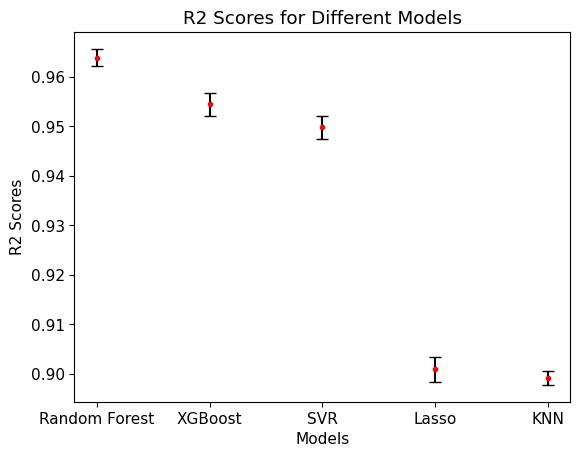

In [187]:
models = ["Random Forest", "XGBoost", "SVR", "Lasso", "KNN"]
r2_mean = [np.mean(rf_r2_scores), np.mean(R2_reduced_xgb), np.mean(svr_r2_scores), np.mean(lasso_r2_scores), np.mean(knn_r2_scores)]
r2_std = [np.std(rf_r2_scores), np.std(R2_reduced_xgb), np.std(svr_r2_scores), np.std(lasso_r2_scores), np.std(knn_r2_scores)]

# Plotting error bars only
plt.errorbar(models, r2_mean, yerr=r2_std, fmt='o', markersize=3, color='red', ecolor='black', capsize=4)

#'#FFBF76', '#B396CB'

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('R2 Scores')
plt.title('R2 Scores for Different Models')
plt.savefig("/Users/winniezhang/Desktop/data1030_project/R2_Score_plot.png", format='png', dpi = 1200)
# Display the plot
plt.show()

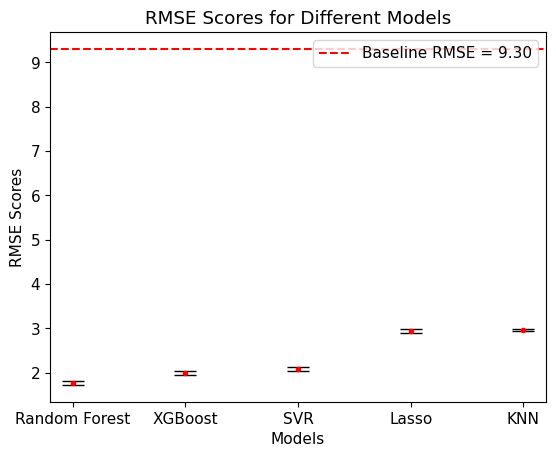

In [191]:
models = ["Random Forest", "XGBoost", "SVR", "Lasso", "KNN"]
rmse_mean = [np.mean(rf_test_scores), np.mean(RMSE_reduced_xgb), np.mean(svr_test_scores), np.mean(lasso_test_scores), np.mean(knn_test_scores)]
rmse_std = [np.std(rf_test_scores), np.std(RMSE_reduced_xgb), np.std(svr_test_scores), np.std(lasso_test_scores), np.std(knn_test_scores)]

# Plotting error bars only
plt.errorbar(models, rmse_mean, yerr=rmse_std, fmt='o', markersize=3, color='red', ecolor='black', capsize=8)
plt.axhline(y = baseline_RMSE, linestyle = '--', color = 'red', label = "Baseline RMSE = 9.30")
# Adding labels and title
plt.xlabel('Models')
plt.ylabel('RMSE Scores')
plt.title('RMSE Scores for Different Models')
plt.legend(bbox_to_anchor = (1.0, 1), loc = 'upper right') 
plt.savefig("/Users/winniezhang/Desktop/data1030_project/RMSE_Score_plot.png", format='png', dpi = 1200)
# Display the plot
plt.show()

In [269]:
X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state=42*4)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=42*4)

In [270]:

# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# little hacky, but collect feature names
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(f'preprocessed train size: {df_train.shape}')
#drop highly correlated column
df_train_drop_correlated = df_train.drop(columns = ['onehot__cab_type_Lyft'])
# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(f'preprocessed validation size: {df_CV.shape}')
#drop highly correlated column
df_CV_drop_correlated = df_CV.drop(columns = ['onehot__cab_type_Lyft'])
# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
#drop highly correlated column
df_test_drop_correlated = df_test.drop(columns = ['onehot__cab_type_Lyft'])
print(f'preprocessed test size: {df_test.shape}')

preprocessed train size: (36000, 37)
preprocessed validation size: (12000, 37)
preprocessed test size: (12000, 37)


In [281]:
feature_name_removed_lyft = np.delete(feature_names,4)

In [282]:
feature_name_removed_lyft

array(['ord__ride_type', 'ord__surge_multiplier', 'ord__Hour_of_day',
       'ord__day_of_week', 'onehot__cab_type_Uber',
       'onehot__destination_Back Bay', 'onehot__destination_Beacon Hill',
       'onehot__destination_Boston University',
       'onehot__destination_Fenway',
       'onehot__destination_Financial District',
       'onehot__destination_Haymarket Square',
       'onehot__destination_North End',
       'onehot__destination_North Station',
       'onehot__destination_Northeastern University',
       'onehot__destination_South Station',
       'onehot__destination_Theatre District',
       'onehot__destination_West End', 'onehot__source_Back Bay',
       'onehot__source_Beacon Hill', 'onehot__source_Boston University',
       'onehot__source_Fenway', 'onehot__source_Financial District',
       'onehot__source_Haymarket Square', 'onehot__source_North End',
       'onehot__source_North Station',
       'onehot__source_Northeastern University',
       'onehot__source_South

Refit model with the best parameters for global and local importance 

In [283]:
#Best model and best parameter
param_grid = {
    'n_estimators': [300],
    'max_depth': [10]
}
ML_algo = RandomForestRegressor(random_state = 42*4)
ML_algo.set_params(**ParameterGrid(param_grid)[0])

ML_algo.fit(df_train_drop_correlated,y_train)

# predict on validation 
y_CV_pred = ML_algo.predict(df_CV_drop_correlated)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))

# predict on test 
y_test_pred = ML_algo.predict(df_test_drop_correlated)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('the test R2:',r2_score(y_test,y_test_pred))

the CV RMSE: 1.741349845729576
the test RMSE: 1.8589116606043894
the test R2: 0.9604336565543051


In [284]:
np.random.seed(42*4)

nr_runs = 10
scores = np.zeros([len(feature_name_removed_lyft),nr_runs])

test_score = ML_algo.score(df_test_drop_correlated,y_test)
print('test score = ',test_score)

# loop through the features
for i in range(len(feature_name_removed_lyft)):
    print('shuffling '+str(feature_name_removed_lyft[i]))
    acc_scores = []
    for j in range(nr_runs):
        X_test_shuffled = df_test_drop_correlated.copy()
        X_test_shuffled[feature_name_removed_lyft[i]] = np.random.permutation(df_test_drop_correlated[feature_name_removed_lyft[i]].values)
        acc_scores.append(ML_algo.score(X_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
    scores[i] = acc_scores

test score =  0.9604336565543051
shuffling ord__ride_type
   shuffled test score: -0.636 +/- 0.017
shuffling ord__surge_multiplier
   shuffled test score: 0.879 +/- 0.003
shuffling ord__Hour_of_day
   shuffled test score: 0.961 +/- 0.0
shuffling ord__day_of_week
   shuffled test score: 0.96 +/- 0.0
shuffling onehot__cab_type_Uber
   shuffled test score: 0.941 +/- 0.001
shuffling onehot__destination_Back Bay
   shuffled test score: 0.96 +/- 0.0
shuffling onehot__destination_Beacon Hill
   shuffled test score: 0.96 +/- 0.0
shuffling onehot__destination_Boston University
   shuffled test score: 0.96 +/- 0.0
shuffling onehot__destination_Fenway
   shuffled test score: 0.96 +/- 0.0
shuffling onehot__destination_Financial District
   shuffled test score: 0.959 +/- 0.0
shuffling onehot__destination_Haymarket Square
   shuffled test score: 0.96 +/- 0.0
shuffling onehot__destination_North End
   shuffled test score: 0.96 +/- 0.0
shuffling onehot__destination_North Station
   shuffled test score

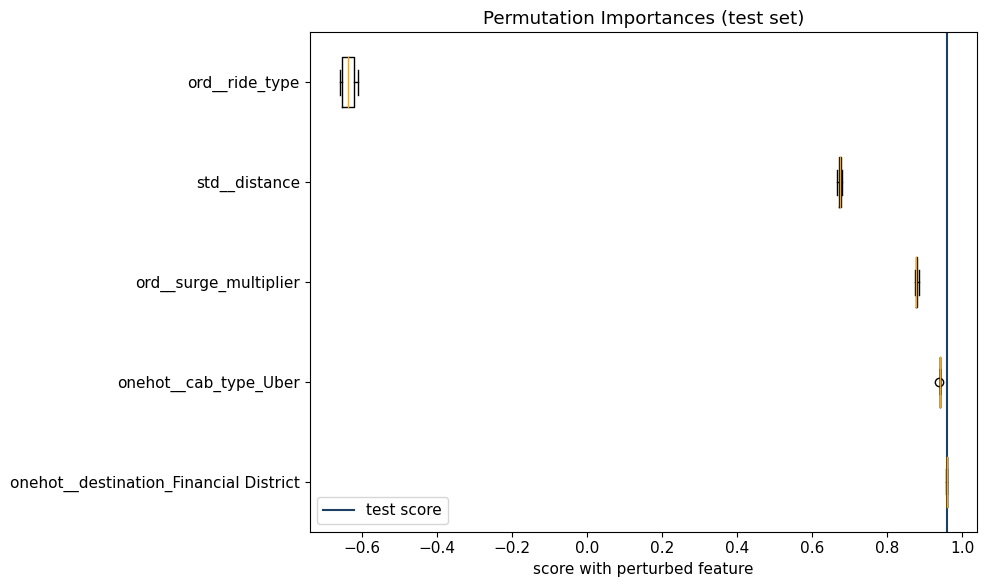

In [347]:
sns.set_palette(['#1c4061', 'orange'])
sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
top10 = sorted_indcs[-5:]
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(10,6))
#plt.boxplot(scores.T,labels=feature_names,vert=False)
plt.boxplot(scores[top10].T,labels=feature_name_removed_lyft[top10],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.legend()
plt.tight_layout()
plt.savefig("/Users/winniezhang/Desktop/data1030_project/Important_Feature_Permutation_box.png", format='png', dpi = 1200)
plt.show()

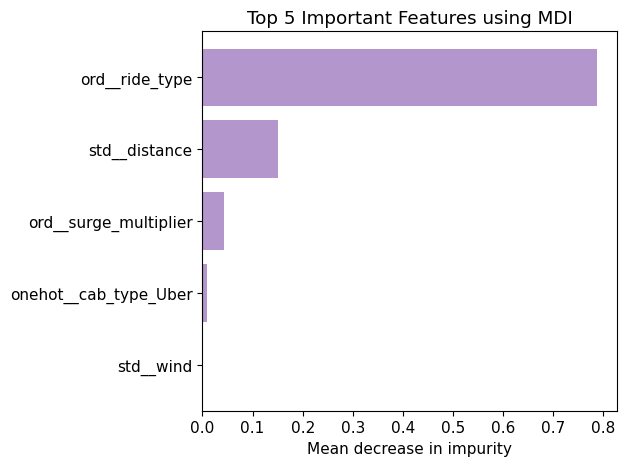

In [305]:
sns.set_palette(['#B396CB'])
importances = ML_algo.feature_importances_
forest_importances = pd.Series(importances, index=feature_name_removed_lyft)
sorted_importance = forest_importances.sort_values(ascending=False)
best_5_parameters = sorted_importance[:5]
plt.barh(best_5_parameters.index[::-1], best_5_parameters[::-1])
plt.title("Top 5 Important Features using MDI")
plt.xlabel("Mean decrease in impurity")
plt.tight_layout()
plt.savefig("/Users/winniezhang/Desktop/data1030_project/Important_Feature_MDI.png", format='png', dpi = 1200)
plt.show()

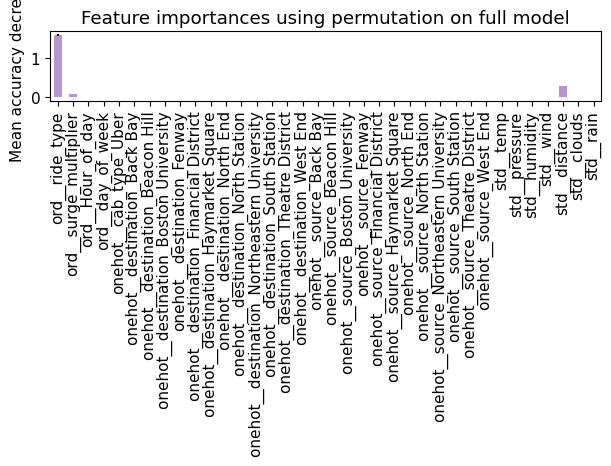

In [307]:
from sklearn.inspection import permutation_importance

ML_algo.fit(df_train_drop_correlated,y_train)

result = permutation_importance(ML_algo, df_test_drop_correlated, y_test, n_repeats=10, random_state=42 * 4, n_jobs=2)

forest_importances = pd.Series(result.importances_mean, index=feature_name_removed_lyft)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

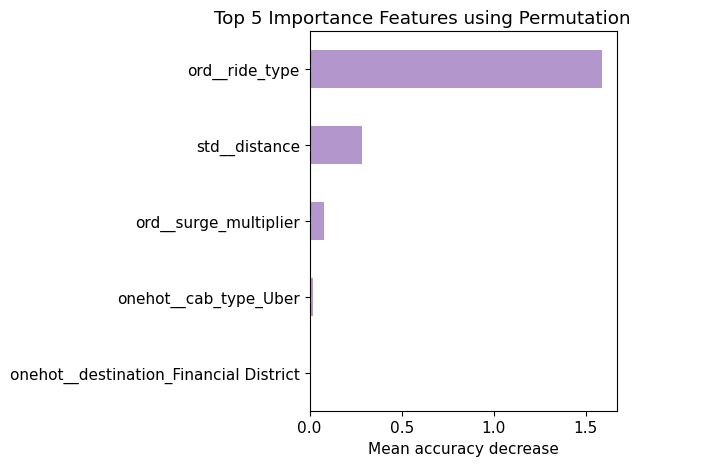

In [346]:
sorted_importance = forest_importances.sort_values(ascending=False)
best_5_parameters = sorted_importance[:5]
fig, ax = plt.subplots()
best_5_parameters.plot.barh(ax=ax)
ax.set_title("Top 5 Importance Features using Permutation              ")
ax.invert_yaxis()
ax.set_xlabel("Mean accuracy decrease")
plt.tight_layout()
plt.savefig("/Users/winniezhang/Desktop/data1030_project/Important_Feature_Permutation.png", format='png', dpi = 1200)
plt.show()

In [309]:
import shap

explainer = shap.Explainer(ML_algo)
shap_values = explainer.shap_values(df_test_drop_correlated)
global_shap_values = np.abs(shap_values).mean(axis=0)
top_feature_indices = np.argsort(global_shap_values)[-5:]
top_features = df_test_drop_correlated.columns[top_feature_indices]
top_importance_values = global_shap_values[top_feature_indices]

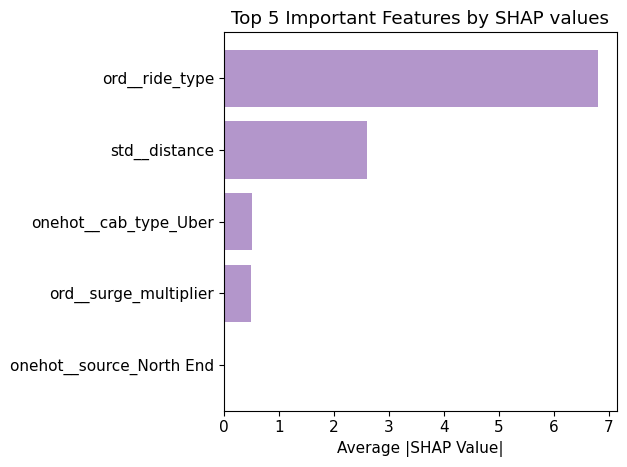

In [310]:
plt.barh(top_features, top_importance_values)
plt.xlabel('Average |SHAP Value|')
plt.title('Top 5 Important Features by SHAP values')
plt.tight_layout()
plt.savefig("/Users/winniezhang/Desktop/data1030_project/Important_Feature_SHAP.png", format='png', dpi = 1200)
plt.show()

In [316]:
shap.initjs()

In [333]:
shap.force_plot(explainer.expected_value, shap_values[0], df_test_drop_correlated.iloc[[0]], feature_names=df_test_drop_correlated.columns,show=False,  
                matplotlib=True)
plt.savefig("/Users/winniezhang/Desktop/data1030_project/force_plot_1.png", format='png', dpi = 1200, bbox_inches='tight')

In [334]:
shap.force_plot(explainer.expected_value, shap_values[35], df_test_drop_correlated.iloc[[35]], feature_names=df_test_drop_correlated.columns, show = False,  
               matplotlib = True)
plt.savefig("/Users/winniezhang/Desktop/data1030_project/force_plot_2.png", format='png', dpi = 1200, bbox_inches='tight')

In [338]:
shap.force_plot(explainer.expected_value, shap_values[1260], df_test_drop_correlated.iloc[[1260]],  
                feature_names=df_test_drop_correlated.columns, show = False, matplotlib = True)
plt.savefig("/Users/winniezhang/Desktop/data1030_project/force_plot_3.png", format='png', dpi = 1200, bbox_inches='tight')

In [337]:
shap.force_plot(explainer.expected_value, shap_values[344], df_test_drop_correlated.iloc[[344]],  
                feature_names=df_test_drop_correlated.columns, show = False, matplotlib = True)
plt.savefig("/Users/winniezhang/Desktop/data1030_project/force_plot_4.png", format='png', dpi = 1200, bbox_inches='tight')

In [336]:
df_test_drop_correlated[df_test_drop_correlated['ord__surge_multiplier'] == 3]

,ord__ride_type,ord__surge_multiplier,ord__Hour_of_day,ord__day_of_week,onehot__cab_type_Uber,onehot__destination_Back Bay,onehot__destination_Beacon Hill,onehot__destination_Boston University,onehot__destination_Fenway,onehot__destination_Financial District,...,onehot__source_South Station,onehot__source_Theatre District,onehot__source_West End,std__temp,std__pressure,std__humidity,std__wind,std__distance,std__clouds,std__rain
57,5.0,3.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.206601,-0.767596,0.164661,0.540759,1.012710,0.486814,0.233872
344,3.0,3.0,15.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.525489,0.736404,-0.302789,0.819296,-0.409756,0.550894,1.385297
581,5.0,3.0,15.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.049182,-1.377036,-0.744270,0.580287,0.235213,-1.221978,-0.590471
730,2.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,-0.218076,-0.883692,-0.354728,1.086802,2.072933,-0.773420,0.027343
750,4.0,3.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.128398,0.378006,1.528056,-1.326267,0.738819,0.919352,-0.350397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10762,1.0,3.0,9.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.151116,0.839018,1.021652,-0.286579,-0.409756,0.775173,1.204540
11203,1.0,3.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.750929,-0.750369,-1.471414,-0.082502,1.922735,0.102336,0.311463
11367,2.0,3.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-0.855599,-1.425971,0.567187,-0.321511,0.164532,-1.697236,-1.711235
11368,1.0,3.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.469137,-0.468744,1.177469,-0.035620,1.127568,0.839252,-0.222511


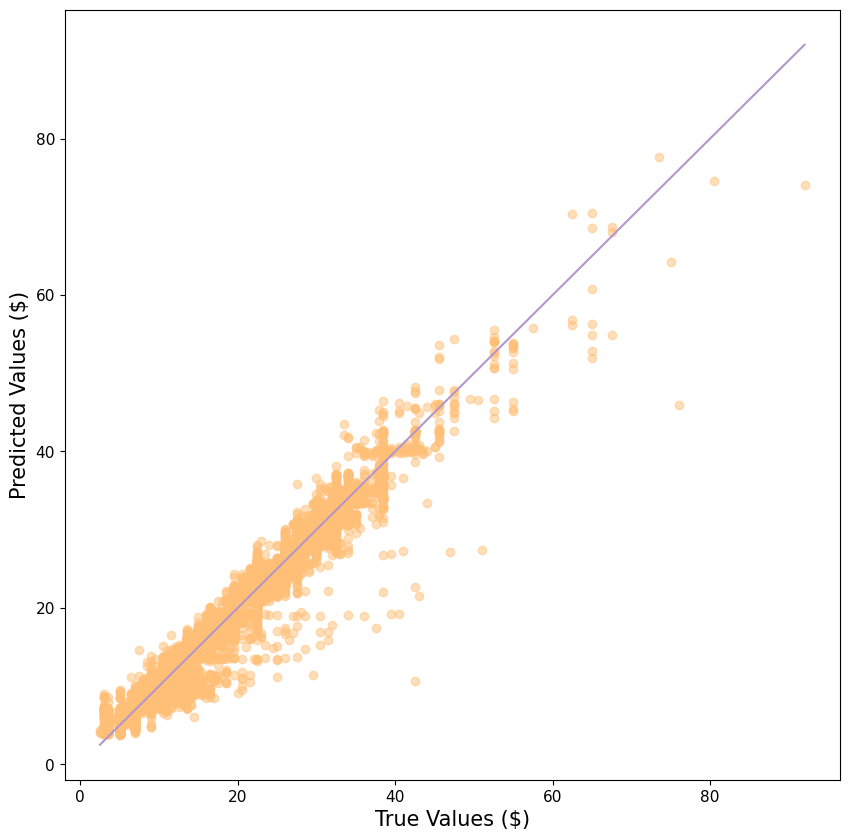

In [343]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, y_test_pred, alpha = 0.5, color ='#FFBF76')

p1 = max(max(y_test_pred), max(y_test))
p2 = min(min(y_test_pred), min(y_test))
plt.plot([p1, p2], [p1, p2], color = '#B396CB')
plt.xlabel('True Values ($)', fontsize=15)
plt.ylabel('Predicted Values ($)', fontsize=15)
#plt.axis('equal')
plt.savefig("/Users/winniezhang/Desktop/data1030_project/predicted_vs_true.png", format='png', dpi = 1200)
plt.show()